# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone git@github.com:jcmayoral/PyTorch-YOLOv3.git yolov3

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [2]:
from yolov3.models import Darknet

#model_4classes = Darknet(config_path="yolov3/config/yolov3-custom.cfg")

In [3]:
#nparams = sum(p.numel() for p in model_4classes.parameters())
#print (f"{nparams:,}")

In [4]:
!ls
!pwd

'attempt yolo.ipynb'		   __pycache__
 checkpoints			   rcnntutorial.ipynb
 coco_eval.py			   scalar
 coco_utils.py			   svmpersons.ipynb
 decisiontreepersons.ipynb	   testingyolo
 engine.py			   transforms.py
 linearregressionpersons.ipynb	   utils.py
 logisticregressionpersons.ipynb   vision
 output				   yolov3
 pointnet.ipynb
/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [5]:
from __future__ import division

from yolov3.models import *
from yolov3.utils.logger import *
from yolov3.utils.utils import *
from yolov3.utils.datasets import *
from yolov3.utils.parse_config import *
from yolov3.test import evaluate

from terminaltables import AsciiTable

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim


"""
parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
parser.add_argument("--batch_size", type=int, default=8, help="size of each image batch")
parser.add_argument("--gradient_accumulations", type=int, default=2, help="number of gradient accums before step")
parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
parser.add_argument("--data_config", type=str, default="config/coco.data", help="path to data config file")
parser.add_argument("--pretrained_weights", type=str, help="if specified starts from checkpoint model")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
parser.add_argument("--checkpoint_interval", type=int, default=1, help="interval between saving model weights")
parser.add_argument("--evaluation_interval", type=int, default=1, help="interval evaluations on validation set")
parser.add_argument("--compute_map", default=False, help="if True computes mAP every tenth batch")
parser.add_argument("--multiscale_training", default=True, help="allow for multi-scale training")
opt = parser.parse_args()
print(opt)
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config("yolov3/config/jose.data")
#data_config = { line.split()[0] : line.split()[1] for line in open("yolov3/config/jose.data") }

#parse_data_config(opt.data_config)bb
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

print(class_names)

# Initiate model
model = Darknet("yolov3/config/yolov3-custom.cfg").to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint
"""
if opt.pretrained_weights:
    if opt.pretrained_weights.endswith(".pth"):
        model.load_state_dict(torch.load(opt.pretrained_weights))
    else:
        model.load_darknet_weights(opt.pretrained_weights)
"""



/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

['Lethal', 'Danger', 'Warning', 'Safe']


'\nif opt.pretrained_weights:\n    if opt.pretrained_weights.endswith(".pth"):\n        model.load_state_dict(torch.load(opt.pretrained_weights))\n    else:\n        model.load_darknet_weights(opt.pretrained_weights)\n'

In [6]:
bs = 2
nepochs = 20
ncpu = 6
gradient_accumulations = 2
evaluation_interval = 2
checkpoint_interval = 2
img_size = 416

In [7]:
!pwd


/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [8]:
# Get dataloader
#For some reason augment or multiscale fails
dataset = ListDataset(train_path, augment=False, multiscale=False)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=ncpu,
    pin_memory=False,
    collate_fn=dataset.collate_fn,
)

optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

try:
    os.makedirs("testingyolo")
except:
    pass

#logger = Logger("testingyolo/logs")


for epoch in range(nepochs):
    model.train()
    start_time = time.time()
    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        #print(_)
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, nepochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        # Log metrics at each YOLO layer
        for i, metric in enumerate(metrics):
            formats = {m: "%.6f" for m in metrics}
            formats["grid_size"] = "%2d"
            formats["cls_acc"] = "%.2f%%"
            row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
            metric_table += [[metric, *row_metrics]]

            # Tensorboard logging
            tensorboard_log = []
            for j, yolo in enumerate(model.yolo_layers):
                for name, metric in yolo.metrics.items():
                    if name != "grid_size":
                        tensorboard_log += [(f"{name}_{j+1}", metric)]
            tensorboard_log += [("loss", loss.item())]
            #logger.list_of_scalars_summary(tensorboard_log, batches_done)

        log_str += AsciiTable(metric_table).table
        log_str += f"\nTotal loss {loss.item()}"

        # Determine approximate time left for epoch
        epoch_batches_left = len(dataloader) - (batch_i + 1)
        time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
        log_str += f"\n---- ETA {time_left}"

        print(log_str)

        model.seen += imgs.size(0)

    if epoch % evaluation_interval == 0:
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            path=valid_path,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=img_size,
            batch_size=8,
        )
        """
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        logger.list_of_scalars_summary(evaluation_metrics, epoch)
        """
        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

    if epoch % checkpoint_interval == 0:
        torch.save(model.state_dict(), f"testingyolo/checkpoints/yolov3_ckpt_%d.pth" % epoch)



---- [Epoch 0/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 66.424538    | 64.962105    | 71.215759    |
| x          | 0.220630     | 0.054272     | 0.051376     |
| y          | 0.231855     | 0.075903     | 0.054138     |
| w          | 1.471109     | 0.234005     | 0.315637     |
| h          | 0.641058     | 0.168957     | 1.810115     |
| conf       | 63.074959    | 63.728512    | 68.316093    |
| cls        | 0.784926     | 0.700453     | 0.668399     |
| cls_acc    | 33.33%       | 0.00%        | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.420100     | 0.496810     | 0.500378     |
| co


---- [Epoch 0/20, Batch 8/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 41.928829    | 47.861748    | 56.818237    |
| x          | 0.073863     | 0.028763     | 0.065585     |
| y          | 0.033344     | 0.025187     | 0.025872     |
| w          | 0.618646     | 3.986213     | 0.472494     |
| h          | 2.231582     | 3.485928     | 4.596612     |
| conf       | 38.686043    | 39.784283    | 50.998798    |
| cls        | 0.285350     | 0.551372     | 0.658876     |
| cls_acc    | 100.00%      | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.003736     | 0.179596     | 0.397810     |
| co


---- [Epoch 0/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 13.624086    | 20.387247    | 37.030174    |
| x          | 0.008300     | 0.038513     | 0.062276     |
| y          | 0.189641     | 0.175202     | 0.058609     |
| w          | 1.239605     | 0.105949     | 0.173509     |
| h          | 1.387959     | 0.309673     | 0.471623     |
| conf       | 10.293449    | 19.220461    | 35.655235    |
| cls        | 0.505132     | 0.537450     | 0.608921     |
| cls_acc    | 33.33%       | 66.67%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.128062     | 0.165068     | 0.333045     |
| c


---- [Epoch 0/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 8.735240     | 13.814983    | 26.487230    |
| x          | 0.077738     | 0.014817     | 0.121883     |
| y          | 0.136640     | 0.099836     | 0.041969     |
| w          | 1.530357     | 0.974206     | 0.307499     |
| h          | 0.995384     | 1.770237     | 0.103443     |
| conf       | 5.468422     | 10.396278    | 25.291349    |
| cls        | 0.526700     | 0.559608     | 0.621089     |
| cls_acc    | 0.00%        | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.115682     | 0.171387     | 0.256949     |
| c


---- [Epoch 0/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 6.925183     | 8.992853     | 21.028006    |
| x          | 0.104748     | 0.078851     | 0.024212     |
| y          | 0.133912     | 0.085815     | 0.124900     |
| w          | 1.121420     | 0.615238     | 0.545988     |
| h          | 0.306685     | 0.188073     | 0.037397     |
| conf       | 4.716166     | 7.551699     | 19.779758    |
| cls        | 0.542251     | 0.473176     | 0.515750     |
| cls_acc    | 50.00%       | 75.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.110173     | 0.140030     | 0.243609     |
| c


---- [Epoch 0/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 6.396479     | 6.323589     | 15.863024    |
| x          | 0.077634     | 0.156980     | 0.125791     |
| y          | 0.089096     | 0.003666     | 0.171398     |
| w          | 1.194571     | 0.051170     | 0.250735     |
| h          | 0.861575     | 0.014983     | 0.430395     |
| conf       | 3.694138     | 5.611156     | 14.353620    |
| cls        | 0.479464     | 0.485635     | 0.531085     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.105662     | 0.115065     | 0.181112     |
| c


---- [Epoch 0/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.770239     | 5.699775     | 13.054401    |
| x          | 0.011046     | 0.001822     | 0.215042     |
| y          | 0.189965     | 0.222244     | 0.165540     |
| w          | 0.166731     | 0.289622     | 0.324347     |
| h          | 0.134227     | 0.034328     | 0.345495     |
| conf       | 5.024422     | 4.551925     | 11.397364    |
| cls        | 0.243849     | 0.599833     | 0.606613     |
| cls_acc    | 100.00%      | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.035367     | 0.243038     | 0.341765     |
| c


---- [Epoch 0/20, Batch 52/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.186649     | 6.255817     | 10.337491    |
| x          | 0.050235     | 0.069313     | 0.066819     |
| y          | 0.036183     | 0.034746     | 0.025094     |
| w          | 0.403229     | 0.115630     | 0.189678     |
| h          | 0.247210     | 0.241740     | 0.155275     |
| conf       | 4.038091     | 5.442488     | 9.461329     |
| cls        | 0.411700     | 0.351899     | 0.439296     |
| cls_acc    | 33.33%       | 66.67%       | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.108126     | 0.036945     | 0.124735     |
| c


---- [Epoch 0/20, Batch 59/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.591336     | 4.056211     | 8.050906     |
| x          | 0.034108     | 0.118130     | 0.113131     |
| y          | 0.024057     | 0.035466     | 0.065783     |
| w          | 0.073133     | 0.066767     | 0.051452     |
| h          | 0.162752     | 0.105782     | 0.057291     |
| conf       | 3.924227     | 3.257218     | 7.294959     |
| cls        | 0.373060     | 0.472848     | 0.468290     |
| cls_acc    | 66.67%       | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.077987     | 0.329787     | 0.338678     |
| c


---- [Epoch 0/20, Batch 66/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 6.310499     | 7.815996     | 8.925831     |
| x          | 0.026526     | 0.099330     | 0.115541     |
| y          | 0.066636     | 0.003584     | 0.078007     |
| w          | 0.109157     | 0.874842     | 0.882423     |
| h          | 0.356442     | 1.623398     | 0.193838     |
| conf       | 5.285503     | 4.343953     | 7.117480     |
| cls        | 0.466235     | 0.870888     | 0.538543     |
| cls_acc    | 66.67%       | 0.00%        | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.051793     | 0.195350     | 0.202116     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 0/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.569687     | 3.060944     | 6.220388     |
| x          | 0.010736     | 0.114387     | 0.187600     |
| y          | 0.126966     | 0.028642     | 0.093176     |
| w          | 0.170649     | 0.006323     | 0.039091     |
| h          | 0.134393     | 0.045762     | 0.004351     |
| conf       | 3.752213     | 2.426503     | 5.433245     |
| cls        | 0.374731     | 0.439327     | 0.462926     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.083666     | 0.390368     | 0.458197     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 6615.62it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.33571 |
| 2     | Warning    | 0.00000 |
+-------+------------+---------+
---- mAP 0.11190476190476188

---- [Epoch 1/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 8.621015     | 4.322464     | 7.097409     |
| x          | 0.068754     | 0.027810     | 0.093553     |
| y          | 0.107611     | 0.002398     | 0.022278     |
| w          | 2.143876     | 0.090661     | 0.075996     |
| h          | 2.082309     | 0.232758     | 0.046855     |
| conf       | 3.308771     | 3.503230     | 6.444990     |
| cls        | 0.909693     | 0.465607     | 0.413737     |
| cls_acc    | 0.00%        | 50.00%       |


---- [Epoch 1/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.936440     | 5.252781     | 6.491280     |
| x          | 0.028074     | 0.016445     | 0.094934     |
| y          | 0.056864     | 0.057202     | 0.024922     |
| w          | 0.143208     | 0.564245     | 0.124455     |
| h          | 0.123624     | 0.778326     | 0.303748     |
| conf       | 4.280685     | 3.482536     | 5.537887     |
| cls        | 0.303985     | 0.354026     | 0.405335     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.111111     | 0.000000     |
| conf_obj   | 0.039885     | 0.305039     | 0.252933     |
| co


---- [Epoch 1/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.860940     | 3.241678     | 5.168460     |
| x          | 0.062102     | 0.082265     | 0.041494     |
| y          | 0.012797     | 0.087396     | 0.123515     |
| w          | 0.595829     | 0.003902     | 0.063793     |
| h          | 0.543475     | 0.067837     | 0.086034     |
| conf       | 3.159383     | 2.579923     | 4.372852     |
| cls        | 0.487356     | 0.420355     | 0.480772     |
| cls_acc    | 25.00%       | 50.00%       | 25.00%       |
| recall50   | 0.000000     | 0.000000     | 0.250000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.013158     |
| conf_obj   | 0.165183     | 0.369458     | 0.538939     |
| c


---- [Epoch 1/20, Batch 22/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.475339     | 4.039241     | 4.880141     |
| x          | 0.038089     | 0.053054     | 0.038289     |
| y          | 0.148667     | 0.110339     | 0.058113     |
| w          | 0.354446     | 0.171364     | 0.093226     |
| h          | 0.340494     | 0.014927     | 0.160619     |
| conf       | 3.207448     | 3.295166     | 4.016316     |
| cls        | 0.386195     | 0.394391     | 0.513578     |
| cls_acc    | 50.00%       | 75.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.250000     |
| recall75   | 0.000000     | 0.250000     | 0.000000     |
| precision  | 0.000000     | 0.285714     | 0.043478     |
| conf_obj   | 0.169441     | 0.355707     | 0.415574     |
| c


---- [Epoch 1/20, Batch 29/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.102913     | 3.927709     | 5.337197     |
| x          | 0.024687     | 0.004482     | 0.182295     |
| y          | 0.018483     | 0.149520     | 0.045303     |
| w          | 0.268617     | 0.122215     | 0.267766     |
| h          | 0.506412     | 0.072757     | 0.243374     |
| conf       | 2.603123     | 3.151971     | 3.820871     |
| cls        | 0.681591     | 0.426762     | 0.777588     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.500000     | 0.062500     |
| conf_obj   | 0.202513     | 0.255917     | 0.369649     |
| c


---- [Epoch 1/20, Batch 36/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.137167     | 4.235997     | 3.713913     |
| x          | 0.040341     | 0.140617     | 0.074969     |
| y          | 0.032003     | 0.037766     | 0.071313     |
| w          | 0.021219     | 0.249555     | 0.034854     |
| h          | 0.056910     | 0.459235     | 0.116248     |
| conf       | 3.519593     | 2.701285     | 3.019798     |
| cls        | 0.467102     | 0.647539     | 0.396731     |
| cls_acc    | 50.00%       | 0.00%        | 75.00%       |
| recall50   | 0.000000     | 0.000000     | 0.250000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.023256     |
| conf_obj   | 0.125455     | 0.285120     | 0.586921     |
| c


---- [Epoch 1/20, Batch 43/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.311284     | 3.267266     | 4.178995     |
| x          | 0.163680     | 0.019099     | 0.101795     |
| y          | 0.040971     | 0.129871     | 0.117377     |
| w          | 0.146237     | 0.007915     | 0.102633     |
| h          | 0.107315     | 0.032932     | 0.078041     |
| conf       | 3.250757     | 2.736261     | 3.394741     |
| cls        | 0.602323     | 0.341188     | 0.384408     |
| cls_acc    | 33.33%       | 100.00%      | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.076923     | 0.014493     |
| conf_obj   | 0.115674     | 0.411706     | 0.551538     |
| c


---- [Epoch 1/20, Batch 50/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.197851     | 1.930103     | 3.304812     |
| x          | 0.072342     | 0.026313     | 0.031830     |
| y          | 0.019275     | 0.065668     | 0.066593     |
| w          | 0.016456     | 0.038243     | 0.084316     |
| h          | 0.012263     | 0.028921     | 0.001016     |
| conf       | 2.737700     | 1.324854     | 2.669273     |
| cls        | 0.339815     | 0.446104     | 0.451784     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.200000     | 0.025641     |
| conf_obj   | 0.156486     | 0.663396     | 0.577132     |
| c


---- [Epoch 1/20, Batch 57/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.958828     | 2.582036     | 3.942832     |
| x          | 0.040660     | 0.073712     | 0.194949     |
| y          | 0.023595     | 0.077137     | 0.132130     |
| w          | 0.251754     | 0.323635     | 0.284102     |
| h          | 0.009005     | 0.014134     | 0.043992     |
| conf       | 3.350874     | 1.694498     | 2.801475     |
| cls        | 0.282940     | 0.398920     | 0.486184     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 0.000000     | 0.666667     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.111111     | 0.000000     |
| conf_obj   | 0.088518     | 0.682839     | 0.484352     |
| c


---- [Epoch 1/20, Batch 64/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.806890     | 3.518186     | 4.677024     |
| x          | 0.111603     | 0.006258     | 0.059945     |
| y          | 0.101209     | 0.102775     | 0.113906     |
| w          | 0.189874     | 0.426649     | 0.210755     |
| h          | 0.054363     | 0.064460     | 0.212830     |
| conf       | 3.094947     | 2.328089     | 3.459803     |
| cls        | 0.254894     | 0.589955     | 0.619785     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.066667     | 0.000000     |
| conf_obj   | 0.129786     | 0.497443     | 0.312034     |
| c


---- [Epoch 2/20, Batch 3/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.855581     | 2.760896     | 4.511693     |
| x          | 0.095993     | 0.021757     | 0.076347     |
| y          | 0.044133     | 0.032435     | 0.016799     |
| w          | 0.184378     | 0.143104     | 0.167560     |
| h          | 0.070371     | 0.076481     | 0.077043     |
| conf       | 3.249063     | 1.946978     | 3.565568     |
| cls        | 0.211642     | 0.540140     | 0.608376     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.117476     | 0.452324     | 0.289688     |
| co


---- [Epoch 2/20, Batch 11/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.350559     | 3.487590     | 4.199419     |
| x          | 0.085810     | 0.040319     | 0.144787     |
| y          | 0.034595     | 0.021647     | 0.057570     |
| w          | 0.357822     | 0.336890     | 0.027011     |
| h          | 0.644956     | 0.129418     | 0.050850     |
| conf       | 2.860431     | 2.755124     | 3.699379     |
| cls        | 0.366946     | 0.204192     | 0.219822     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.021277     |
| conf_obj   | 0.168633     | 0.383965     | 0.404889     |
| c


---- [Epoch 2/20, Batch 18/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.080066     | 3.463309     | 4.607746     |
| x          | 0.013479     | 0.075638     | 0.080874     |
| y          | 0.028913     | 0.016611     | 0.104876     |
| w          | 0.042871     | 0.113560     | 0.388751     |
| h          | 0.122958     | 0.136812     | 0.154428     |
| conf       | 3.757796     | 2.607244     | 3.304985     |
| cls        | 0.114049     | 0.513445     | 0.573832     |
| cls_acc    | 100.00%      | 66.67%       | 0.00%        |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.055556     | 0.000000     |
| conf_obj   | 0.136318     | 0.476407     | 0.337328     |
| c


---- [Epoch 2/20, Batch 25/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.771475     | 2.303577     | 3.324461     |
| x          | 0.041075     | 0.056945     | 0.056030     |
| y          | 0.006290     | 0.033791     | 0.039243     |
| w          | 0.040430     | 0.018603     | 0.094665     |
| h          | 0.023350     | 0.051317     | 0.004870     |
| conf       | 3.392169     | 1.804754     | 2.638326     |
| cls        | 0.268160     | 0.338167     | 0.491328     |
| cls_acc    | 66.67%       | 100.00%      | 33.33%       |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.100000     | 0.000000     |
| conf_obj   | 0.152582     | 0.449559     | 0.305428     |
| c


---- [Epoch 2/20, Batch 32/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.633696     | 4.166114     | 5.055478     |
| x          | 0.084940     | 0.089734     | 0.080787     |
| y          | 0.072136     | 0.103843     | 0.050532     |
| w          | 0.290563     | 0.050868     | 0.130852     |
| h          | 0.328641     | 0.053004     | 0.342898     |
| conf       | 3.274560     | 3.273186     | 3.739794     |
| cls        | 0.582856     | 0.595480     | 0.710613     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.135136     | 0.193610     | 0.230695     |
| c


---- [Epoch 2/20, Batch 40/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.378663     | 3.533661     | 4.021379     |
| x          | 0.033277     | 0.018475     | 0.171301     |
| y          | 0.010599     | 0.013863     | 0.089424     |
| w          | 0.144412     | 0.444820     | 0.146382     |
| h          | 0.072189     | 0.184525     | 0.120763     |
| conf       | 2.970925     | 2.621395     | 3.140189     |
| cls        | 0.147261     | 0.250583     | 0.353320     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.199275     | 0.253625     | 0.217924     |
| c


---- [Epoch 2/20, Batch 48/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.977807     | 1.668818     | 2.132507     |
| x          | 0.124804     | 0.032494     | 0.050105     |
| y          | 0.027363     | 0.117192     | 0.074522     |
| w          | 0.036393     | 0.025402     | 0.024682     |
| h          | 0.055709     | 0.011827     | 0.021749     |
| conf       | 2.206165     | 1.029148     | 1.505320     |
| cls        | 0.527373     | 0.452754     | 0.456130     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.306417     | 0.935098     | 0.859957     |
| c


---- [Epoch 2/20, Batch 55/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.593831     | 2.861668     | 2.552273     |
| x          | 0.048368     | 0.075534     | 0.070712     |
| y          | 0.082589     | 0.058018     | 0.035449     |
| w          | 0.662731     | 0.047276     | 0.065396     |
| h          | 0.278518     | 0.042790     | 0.105171     |
| conf       | 2.911438     | 2.258429     | 1.833685     |
| cls        | 0.610187     | 0.379620     | 0.441860     |
| cls_acc    | 0.00%        | 66.67%       | 33.33%       |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.090909     | 0.020833     |
| conf_obj   | 0.187046     | 0.567434     | 0.733804     |
| c


---- [Epoch 2/20, Batch 62/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.649442     | 1.617174     | 2.463709     |
| x          | 0.221293     | 0.152534     | 0.096032     |
| y          | 0.054419     | 0.042472     | 0.017751     |
| w          | 0.060175     | 0.009475     | 0.073219     |
| h          | 0.094200     | 0.000718     | 0.085452     |
| conf       | 3.561523     | 1.029703     | 1.769961     |
| cls        | 0.657833     | 0.382272     | 0.421294     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 1.000000     | 0.000000     |
| recall75   | 0.000000     | 1.000000     | 0.000000     |
| precision  | 0.000000     | 0.250000     | 0.000000     |
| conf_obj   | 0.071962     | 0.792116     | 0.633454     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 2/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.421087     | 1.551638     | 1.939504     |
| x          | 0.060304     | 0.014812     | 0.008999     |
| y          | 0.020130     | 0.067596     | 0.042621     |
| w          | 0.026875     | 0.024838     | 0.059313     |
| h          | 0.177185     | 0.029685     | 0.077999     |
| conf       | 1.844081     | 0.959630     | 1.426506     |
| cls        | 0.292513     | 0.455077     | 0.324066     |
| cls_acc    | 100.00%      | 0.00%        | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.058824     |
| conf_obj   | 0.402109     | 0.827762     | 0.823746     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 2840.39it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.17857 |
| 2     | Warning    | 0.27234 |
+-------+------------+---------+
---- mAP 0.1503047291535121

---- [Epoch 3/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.090904     | 2.632355     | 2.906350     |
| x          | 0.079770     | 0.075131     | 0.021063     |
| y          | 0.019936     | 0.009691     | 0.006073     |
| w          | 0.139921     | 0.040552     | 0.041968     |
| h          | 0.005008     | 0.038463     | 0.030220     |
| conf       | 2.536384     | 2.231054     | 2.526378     |
| cls        | 0.309885     | 0.237463     | 0.280648     |
| cls_acc    | 50.00%       | 100.00%      | 


---- [Epoch 3/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.191691     | 4.313459     | 6.351864     |
| x          | 0.005696     | 0.112875     | 0.009413     |
| y          | 0.070838     | 0.000045     | 0.015066     |
| w          | 0.009530     | 0.116276     | 1.256000     |
| h          | 0.069860     | 0.011385     | 0.528411     |
| conf       | 4.979843     | 3.893023     | 4.158294     |
| cls        | 0.055925     | 0.179855     | 0.384681     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.025356     | 0.146709     | 0.187913     |
| co


---- [Epoch 3/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.717834     | 4.829068     | 4.586165     |
| x          | 0.022652     | 0.179270     | 0.124831     |
| y          | 0.063963     | 0.014677     | 0.045401     |
| w          | 0.718665     | 0.673516     | 0.396603     |
| h          | 0.199153     | 0.176293     | 0.133211     |
| conf       | 4.452851     | 3.482796     | 3.642399     |
| cls        | 0.260551     | 0.302516     | 0.243720     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.038462     |
| conf_obj   | 0.152150     | 0.450779     | 0.450568     |
| c


---- [Epoch 3/20, Batch 22/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.690629     | 3.254364     | 3.935975     |
| x          | 0.055744     | 0.068628     | 0.042436     |
| y          | 0.027169     | 0.097873     | 0.060186     |
| w          | 0.038673     | 0.073941     | 0.334180     |
| h          | 0.135447     | 0.129929     | 0.012882     |
| conf       | 4.079352     | 2.534299     | 3.076609     |
| cls        | 0.354244     | 0.349694     | 0.409681     |
| cls_acc    | 66.67%       | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.173550     | 0.477702     | 0.354710     |
| c


---- [Epoch 3/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.848663     | 2.076771     | 2.933228     |
| x          | 0.139770     | 0.048026     | 0.134034     |
| y          | 0.040591     | 0.088197     | 0.049071     |
| w          | 0.031453     | 0.055434     | 0.131169     |
| h          | 0.001551     | 0.079469     | 0.254291     |
| conf       | 2.462962     | 1.528479     | 1.896819     |
| cls        | 0.172336     | 0.277167     | 0.467845     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.222222     | 0.018182     |
| conf_obj   | 0.190991     | 0.659261     | 0.622223     |
| c


---- [Epoch 3/20, Batch 37/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.817598     | 3.204170     | 4.045294     |
| x          | 0.063022     | 0.037031     | 0.014803     |
| y          | 0.013172     | 0.048067     | 0.154967     |
| w          | 0.105525     | 0.232299     | 0.095905     |
| h          | 0.038242     | 0.072602     | 0.244230     |
| conf       | 3.163710     | 2.529182     | 3.001218     |
| cls        | 0.433927     | 0.284990     | 0.534170     |
| cls_acc    | 33.33%       | 100.00%      | 0.00%        |
| recall50   | 0.000000     | 0.666667     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.181818     | 0.000000     |
| conf_obj   | 0.127949     | 0.404187     | 0.152723     |
| c


---- [Epoch 3/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.501770     | 1.877136     | 2.424515     |
| x          | 0.000203     | 0.145047     | 0.011832     |
| y          | 0.120287     | 0.069705     | 0.092497     |
| w          | 0.000090     | 0.078937     | 0.129468     |
| h          | 0.061388     | 0.202237     | 0.331031     |
| conf       | 3.082389     | 0.824892     | 1.264140     |
| cls        | 0.237412     | 0.556319     | 0.595547     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.125000     | 0.000000     |
| conf_obj   | 0.308213     | 0.831628     | 0.871631     |
| c


---- [Epoch 3/20, Batch 53/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.651663     | 2.381488     | 3.206203     |
| x          | 0.083329     | 0.033290     | 0.137492     |
| y          | 0.025733     | 0.019948     | 0.008062     |
| w          | 0.068922     | 0.021131     | 0.040092     |
| h          | 0.158677     | 0.014067     | 0.052524     |
| conf       | 2.008831     | 2.075711     | 2.683361     |
| cls        | 0.306171     | 0.217341     | 0.284672     |
| cls_acc    | 66.67%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.200000     | 0.066667     |
| conf_obj   | 0.308300     | 0.448847     | 0.448730     |
| c


---- [Epoch 3/20, Batch 60/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.794940     | 4.096427     | 3.022949     |
| x          | 0.036147     | 0.059072     | 0.124094     |
| y          | 0.006764     | 0.029445     | 0.032241     |
| w          | 1.326347     | 0.424037     | 0.136310     |
| h          | 1.505886     | 1.196311     | 0.026317     |
| conf       | 2.415741     | 2.067812     | 2.441802     |
| cls        | 0.504055     | 0.319749     | 0.262186     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.000000     | 0.000000     | 0.050000     |
| conf_obj   | 0.269694     | 0.447180     | 0.424067     |
| c


---- [Epoch 3/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.543004     | 1.478960     | 1.933352     |
| x          | 0.005290     | 0.206257     | 0.195875     |
| y          | 0.000202     | 0.028754     | 0.110711     |
| w          | 0.002046     | 0.014067     | 0.000422     |
| h          | 0.074691     | 0.011831     | 0.001876     |
| conf       | 1.119152     | 0.831233     | 1.182275     |
| cls        | 0.341623     | 0.386818     | 0.442193     |
| cls_acc    | 100.00%      | 100.00%      | 0.00%        |
| recall50   | 1.000000     | 1.000000     | 0.000000     |
| recall75   | 1.000000     | 1.000000     | 0.000000     |
| precision  | 0.500000     | 0.200000     | 0.000000     |
| conf_obj   | 0.716231     | 0.858877     | 0.796256     |
| c


---- [Epoch 4/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.434281     | 2.060501     | 1.780501     |
| x          | 0.029440     | 0.088439     | 0.033985     |
| y          | 0.031148     | 0.002884     | 0.020799     |
| w          | 0.388432     | 0.096697     | 0.048395     |
| h          | 0.346340     | 0.012663     | 0.028626     |
| conf       | 1.193930     | 1.616442     | 1.359463     |
| cls        | 0.444991     | 0.243375     | 0.289233     |
| cls_acc    | 33.33%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.500000     | 0.142857     | 0.055556     |
| conf_obj   | 0.620837     | 0.480732     | 0.676022     |
| co


---- [Epoch 4/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.825330     | 3.580355     | 4.102014     |
| x          | 0.001026     | 0.008419     | 0.211836     |
| y          | 0.088312     | 0.088758     | 0.108071     |
| w          | 0.079442     | 0.022613     | 0.183660     |
| h          | 0.017934     | 0.001556     | 0.028027     |
| conf       | 3.486676     | 3.252349     | 3.348048     |
| cls        | 0.151941     | 0.206661     | 0.222372     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.200000     | 0.058824     |
| conf_obj   | 0.435048     | 0.485113     | 0.488557     |
| c


---- [Epoch 4/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.217687     | 1.929318     | 2.344803     |
| x          | 0.158034     | 0.193990     | 0.034500     |
| y          | 0.007379     | 0.161741     | 0.110697     |
| w          | 0.029562     | 0.016410     | 0.054626     |
| h          | 0.050027     | 0.015726     | 0.058892     |
| conf       | 1.657258     | 1.022186     | 1.512348     |
| cls        | 0.315427     | 0.519265     | 0.573740     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.529090     | 0.922629     | 0.779546     |
| c


---- [Epoch 4/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.553286     | 3.001672     | 2.593208     |
| x          | 0.017147     | 0.053630     | 0.105817     |
| y          | 0.011751     | 0.080538     | 0.066983     |
| w          | 0.008016     | 0.117668     | 0.208906     |
| h          | 0.021935     | 0.084347     | 0.093926     |
| conf       | 2.264602     | 2.141836     | 1.595233     |
| cls        | 0.229834     | 0.523653     | 0.522342     |
| cls_acc    | 100.00%      | 33.33%       | 33.33%       |
| recall50   | 0.666667     | 0.333333     | 0.333333     |
| recall75   | 0.666667     | 0.333333     | 0.333333     |
| precision  | 0.400000     | 0.071429     | 0.013333     |
| conf_obj   | 0.458817     | 0.621964     | 0.788789     |
| c


---- [Epoch 4/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.489892     | 3.609336     | 5.092988     |
| x          | 0.062317     | 0.004992     | 0.091031     |
| y          | 0.075510     | 0.030221     | 0.062808     |
| w          | 0.115230     | 0.085751     | 0.260925     |
| h          | 0.010030     | 0.173716     | 0.256957     |
| conf       | 3.132955     | 3.168041     | 3.993387     |
| cls        | 0.093849     | 0.146616     | 0.427879     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.066667     | 0.000000     |
| conf_obj   | 0.323322     | 0.351307     | 0.284317     |
| c


---- [Epoch 4/20, Batch 47/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.254076     | 1.431839     | 1.894803     |
| x          | 0.013726     | 0.150605     | 0.121036     |
| y          | 0.147004     | 0.112471     | 0.179476     |
| w          | 0.020481     | 0.002081     | 0.109556     |
| h          | 0.027940     | 0.014480     | 0.015200     |
| conf       | 0.781063     | 0.834473     | 1.086591     |
| cls        | 0.263862     | 0.317730     | 0.382944     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.500000     | 0.250000     | 0.060606     |
| conf_obj   | 0.791408     | 0.832485     | 0.758426     |
| c


---- [Epoch 4/20, Batch 55/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.720499     | 2.841130     | 3.331678     |
| x          | 0.038233     | 0.092254     | 0.004706     |
| y          | 0.048593     | 0.061873     | 0.017254     |
| w          | 0.010824     | 0.319957     | 0.079713     |
| h          | 0.084781     | 0.579711     | 0.173964     |
| conf       | 1.392975     | 1.453890     | 2.602470     |
| cls        | 0.145093     | 0.333445     | 0.453571     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.333333     | 0.000000     |
| conf_obj   | 0.570840     | 0.496762     | 0.330369     |
| c


---- [Epoch 4/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.546481     | 1.772826     | 2.450256     |
| x          | 0.040087     | 0.071550     | 0.037771     |
| y          | 0.025489     | 0.054435     | 0.166393     |
| w          | 0.006167     | 0.020932     | 0.036448     |
| h          | 0.047346     | 0.321701     | 0.248320     |
| conf       | 1.095065     | 1.027276     | 1.496589     |
| cls        | 0.332327     | 0.276932     | 0.464734     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.714253     | 0.723624     | 0.653150     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 4/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.187293     | 1.528296     | 2.211730     |
| x          | 0.002005     | 0.180335     | 0.053986     |
| y          | 0.055018     | 0.067559     | 0.081892     |
| w          | 0.074538     | 0.013035     | 0.062124     |
| h          | 0.020828     | 0.014682     | 0.023149     |
| conf       | 0.731578     | 0.892643     | 1.547312     |
| cls        | 0.303326     | 0.360042     | 0.443267     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 1.000000     | 0.000000     |
| precision  | 1.000000     | 0.250000     | 0.035714     |
| conf_obj   | 0.853602     | 0.817557     | 0.676900     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4101.34it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.40725 |
| 2     | Warning    | 0.76640 |
+-------+------------+---------+
---- mAP 0.39121661634421173

---- [Epoch 5/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.821794     | 1.591884     | 2.220724     |
| x          | 0.003857     | 0.160837     | 0.183232     |
| y          | 0.022911     | 0.015054     | 0.012028     |
| w          | 0.033194     | 0.010571     | 0.080911     |
| h          | 0.193039     | 0.020477     | 0.052762     |
| conf       | 1.149353     | 1.101244     | 1.455587     |
| cls        | 0.419441     | 0.283701     | 0.436203     |
| cls_acc    | 33.33%       | 100.00%      |


---- [Epoch 5/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.792116     | 3.502023     | 3.787742     |
| x          | 0.122208     | 0.019248     | 0.097963     |
| y          | 0.027642     | 0.121074     | 0.032086     |
| w          | 0.177739     | 0.078623     | 0.241309     |
| h          | 0.185762     | 0.134204     | 0.291534     |
| conf       | 1.790710     | 2.285552     | 2.322094     |
| cls        | 0.488055     | 0.863323     | 0.802756     |
| cls_acc    | 33.33%       | 0.00%        | 0.00%        |
| recall50   | 0.333333     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.412242     | 0.415299     | 0.333321     |
| co


---- [Epoch 5/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.870789     | 1.783161     | 2.192364     |
| x          | 0.091360     | 0.001946     | 0.155451     |
| y          | 0.007234     | 0.056003     | 0.094455     |
| w          | 0.348317     | 0.131805     | 0.157474     |
| h          | 0.042169     | 0.084539     | 0.071953     |
| conf       | 2.330024     | 0.983183     | 1.150990     |
| cls        | 0.051685     | 0.525684     | 0.562041     |
| cls_acc    | 100.00%      | 50.00%       | 0.00%        |
| recall50   | 0.500000     | 0.000000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.000000     | 0.000000     |
| conf_obj   | 0.420278     | 0.673791     | 0.784814     |
| c


---- [Epoch 5/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.716143     | 2.052175     | 2.675572     |
| x          | 0.059541     | 0.010572     | 0.036482     |
| y          | 0.055860     | 0.021947     | 0.050677     |
| w          | 0.031764     | 0.010003     | 0.146513     |
| h          | 0.004786     | 0.005404     | 0.117832     |
| conf       | 1.142733     | 1.658057     | 1.872829     |
| cls        | 0.421460     | 0.346191     | 0.451239     |
| cls_acc    | 66.67%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.000000     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.000000     | 0.043478     |
| conf_obj   | 0.673138     | 0.538588     | 0.433296     |
| c


---- [Epoch 5/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.651533     | 1.560738     | 1.690500     |
| x          | 0.021085     | 0.012455     | 0.042471     |
| y          | 0.002246     | 0.020022     | 0.035413     |
| w          | 0.010376     | 0.023335     | 0.081946     |
| h          | 0.111998     | 0.021527     | 0.044360     |
| conf       | 1.204779     | 1.005211     | 1.106445     |
| cls        | 0.301048     | 0.478188     | 0.379866     |
| cls_acc    | 100.00%      | 0.00%        | 100.00%      |
| recall50   | 1.000000     | 0.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.000000     | 0.055556     |
| conf_obj   | 0.708723     | 0.890525     | 0.841004     |
| c


---- [Epoch 5/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.967741     | 1.610926     | 2.466831     |
| x          | 0.021716     | 0.055202     | 0.084742     |
| y          | 0.073043     | 0.072093     | 0.055583     |
| w          | 0.224640     | 0.072141     | 0.032576     |
| h          | 0.100320     | 0.006014     | 0.090551     |
| conf       | 1.413559     | 1.202224     | 1.870462     |
| cls        | 0.134463     | 0.203251     | 0.332917     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.333333     | 0.166667     | 0.043478     |
| conf_obj   | 0.583310     | 0.612328     | 0.495047     |
| c


---- [Epoch 5/20, Batch 47/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.083808     | 3.922042     | 4.498977     |
| x          | 0.064499     | 0.085884     | 0.031234     |
| y          | 0.059323     | 0.095562     | 0.169488     |
| w          | 0.009407     | 0.080727     | 0.523388     |
| h          | 0.136905     | 0.054060     | 0.173094     |
| conf       | 3.543258     | 3.349511     | 3.345334     |
| cls        | 0.270416     | 0.256299     | 0.256439     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.282071     | 0.307468     | 0.394634     |
| c


---- [Epoch 5/20, Batch 55/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.886923     | 1.741735     | 2.508642     |
| x          | 0.098868     | 0.006597     | 0.151670     |
| y          | 0.074180     | 0.244271     | 0.186709     |
| w          | 0.517889     | 0.153458     | 0.368706     |
| h          | 0.388480     | 0.010350     | 0.110914     |
| conf       | 1.633419     | 1.189200     | 1.363976     |
| cls        | 0.174087     | 0.137858     | 0.326667     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.125000     | 0.000000     |
| conf_obj   | 0.376511     | 0.582938     | 0.545562     |
| c


---- [Epoch 5/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.345279     | 2.037107     | 1.570433     |
| x          | 0.082244     | 0.024774     | 0.035331     |
| y          | 0.066438     | 0.040310     | 0.052492     |
| w          | 0.432256     | 0.031317     | 0.028907     |
| h          | 0.307285     | 0.069056     | 0.039274     |
| conf       | 1.078131     | 1.627992     | 1.045462     |
| cls        | 0.378924     | 0.243657     | 0.368967     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.000000     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.666667     | 0.000000     | 0.055556     |
| conf_obj   | 0.669071     | 0.519991     | 0.889717     |
| c


---- [Epoch 6/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.518555     | 1.696694     | 1.752390     |
| x          | 0.040027     | 0.010488     | 0.105163     |
| y          | 0.016063     | 0.005436     | 0.097929     |
| w          | 0.034423     | 0.224085     | 0.065221     |
| h          | 0.002032     | 0.066674     | 0.026572     |
| conf       | 1.234041     | 1.203617     | 1.213719     |
| cls        | 0.191970     | 0.186393     | 0.243787     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.142857     | 0.000000     |
| conf_obj   | 0.520157     | 0.619093     | 0.657154     |
| co


---- [Epoch 6/20, Batch 10/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.177219     | 3.858813     | 4.758222     |
| x          | 0.058697     | 0.101156     | 0.078776     |
| y          | 0.068625     | 0.065773     | 0.151763     |
| w          | 1.227764     | 0.128301     | 0.245891     |
| h          | 0.267083     | 0.098665     | 0.566162     |
| conf       | 2.307801     | 3.332797     | 3.359123     |
| cls        | 0.247248     | 0.132122     | 0.356506     |
| cls_acc    | 66.67%       | 100.00%      | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.166667     | 0.000000     |
| conf_obj   | 0.345418     | 0.222396     | 0.204161     |
| c


---- [Epoch 6/20, Batch 18/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.236276     | 2.503817     | 2.206602     |
| x          | 0.040065     | 0.053752     | 0.089960     |
| y          | 0.142721     | 0.103288     | 0.194522     |
| w          | 0.042978     | 0.105078     | 0.300331     |
| h          | 0.111934     | 0.006213     | 0.143043     |
| conf       | 1.389426     | 1.764150     | 0.926748     |
| cls        | 0.509152     | 0.471336     | 0.551997     |
| cls_acc    | 50.00%       | 0.00%        | 50.00%       |
| recall50   | 0.500000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.000000     | 0.000000     |
| conf_obj   | 0.466173     | 0.453697     | 0.846609     |
| c


---- [Epoch 6/20, Batch 26/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.284113     | 1.446092     | 2.134519     |
| x          | 0.013084     | 0.023376     | 0.161374     |
| y          | 0.011414     | 0.020953     | 0.015317     |
| w          | 0.086342     | 0.261315     | 0.390273     |
| h          | 0.045038     | 0.022960     | 0.286561     |
| conf       | 0.984469     | 0.815100     | 0.818129     |
| cls        | 0.143766     | 0.302387     | 0.462865     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 0.666667     | 0.142857     | 0.037037     |
| conf_obj   | 0.823425     | 0.700493     | 0.794516     |
| c


---- [Epoch 6/20, Batch 33/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.033634     | 1.597454     | 1.518130     |
| x          | 0.032253     | 0.077827     | 0.142145     |
| y          | 0.095899     | 0.013446     | 0.053113     |
| w          | 0.078833     | 0.015676     | 0.029383     |
| h          | 0.253203     | 0.012723     | 0.036282     |
| conf       | 1.242640     | 1.166186     | 0.860838     |
| cls        | 0.330806     | 0.311596     | 0.396369     |
| cls_acc    | 75.00%       | 75.00%       | 50.00%       |
| recall50   | 0.250000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.250000     | 0.500000     |
| precision  | 0.166667     | 0.181818     | 0.062500     |
| conf_obj   | 0.650733     | 0.670056     | 0.810991     |
| c


---- [Epoch 6/20, Batch 41/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.843288     | 3.044635     | 2.333018     |
| x          | 0.015451     | 0.026410     | 0.081717     |
| y          | 0.043929     | 0.052556     | 0.147278     |
| w          | 0.234618     | 0.086517     | 0.023751     |
| h          | 0.121859     | 0.068635     | 0.063148     |
| conf       | 2.178623     | 2.411874     | 1.607861     |
| cls        | 0.248808     | 0.398643     | 0.409263     |
| cls_acc    | 100.00%      | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.500000     | 0.000000     | 0.043478     |
| conf_obj   | 0.381610     | 0.364745     | 0.513743     |
| c


---- [Epoch 6/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.620337     | 1.191760     | 1.545405     |
| x          | 0.145519     | 0.075834     | 0.054668     |
| y          | 0.019601     | 0.068952     | 0.099548     |
| w          | 0.121170     | 0.021724     | 0.045589     |
| h          | 0.184599     | 0.023712     | 0.033651     |
| conf       | 1.047621     | 0.815028     | 0.974813     |
| cls        | 0.101827     | 0.186511     | 0.337137     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.400000     | 0.285714     | 0.068966     |
| conf_obj   | 0.776965     | 0.784271     | 0.816687     |
| c


---- [Epoch 6/20, Batch 57/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.101393     | 2.049315     | 1.906319     |
| x          | 0.016958     | 0.156678     | 0.138290     |
| y          | 0.115176     | 0.072079     | 0.009932     |
| w          | 0.511035     | 0.345482     | 0.297948     |
| h          | 0.350096     | 0.315282     | 0.195334     |
| conf       | 1.035107     | 0.821604     | 0.946478     |
| cls        | 0.073021     | 0.338190     | 0.318337     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.000000     | 0.035714     |
| conf_obj   | 0.616823     | 0.659806     | 0.809684     |
| c


---- [Epoch 6/20, Batch 64/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.562292     | 1.626337     | 1.399865     |
| x          | 0.019954     | 0.116119     | 0.099023     |
| y          | 0.055076     | 0.004110     | 0.003658     |
| w          | 0.048736     | 0.006699     | 0.107922     |
| h          | 0.053451     | 0.136135     | 0.020340     |
| conf       | 1.235950     | 1.152635     | 0.790765     |
| cls        | 0.149125     | 0.210639     | 0.378157     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.250000     | 0.142857     | 0.045455     |
| conf_obj   | 0.708327     | 0.682212     | 0.815999     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 6/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.507953     | 1.795117     | 2.335135     |
| x          | 0.064878     | 0.000905     | 0.063556     |
| y          | 0.000121     | 0.004873     | 0.206462     |
| w          | 0.015102     | 0.004696     | 0.046091     |
| h          | 0.043676     | 0.000589     | 0.082249     |
| conf       | 1.334331     | 1.719475     | 1.686183     |
| cls        | 0.049845     | 0.064579     | 0.250595     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.000000     | 0.000000     |
| recall75   | 1.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.000000     | 0.000000     |
| conf_obj   | 0.636902     | 0.340290     | 0.296238     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 3364.41it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.39553 |
| 2     | Warning    | 0.52955 |
+-------+------------+---------+
---- mAP 0.30836068048187526

---- [Epoch 7/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.965813     | 1.544824     | 1.255246     |
| x          | 0.050119     | 0.075933     | 0.072972     |
| y          | 0.047287     | 0.025624     | 0.049805     |
| w          | 0.049642     | 0.017243     | 0.041714     |
| h          | 0.002113     | 0.108867     | 0.007458     |
| conf       | 0.647974     | 1.097713     | 0.872828     |
| cls        | 0.168679     | 0.219442     | 0.210469     |
| cls_acc    | 100.00%      | 50.00%       |


---- [Epoch 7/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.222714     | 1.744210     | 1.579947     |
| x          | 0.083914     | 0.189938     | 0.084379     |
| y          | 0.012720     | 0.077352     | 0.105372     |
| w          | 0.031722     | 0.000535     | 0.049224     |
| h          | 0.014749     | 0.210960     | 0.012187     |
| conf       | 0.986814     | 1.034951     | 1.032344     |
| cls        | 0.092794     | 0.230473     | 0.296442     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 0.500000     | 0.000000     | 1.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.000000     | 0.057143     |
| conf_obj   | 0.716208     | 0.547418     | 0.747309     |
| co


---- [Epoch 7/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.627724     | 1.182614     | 1.265242     |
| x          | 0.006266     | 0.034900     | 0.001127     |
| y          | 0.009970     | 0.008676     | 0.095029     |
| w          | 0.282723     | 0.056410     | 0.035910     |
| h          | 0.143360     | 0.107131     | 0.022885     |
| conf       | 0.922475     | 0.743054     | 0.871871     |
| cls        | 0.262930     | 0.232443     | 0.238421     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 0.500000     | 0.200000     | 0.047619     |
| conf_obj   | 0.651058     | 0.744949     | 0.837345     |
| c


---- [Epoch 7/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.208758     | 1.061844     | 1.025245     |
| x          | 0.030172     | 0.011553     | 0.082964     |
| y          | 0.024320     | 0.016259     | 0.029590     |
| w          | 0.191010     | 0.070037     | 0.024896     |
| h          | 0.156247     | 0.093247     | 0.011797     |
| conf       | 0.658760     | 0.785401     | 0.716217     |
| cls        | 0.148247     | 0.085347     | 0.159780     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 0.666667     | 0.400000     | 0.125000     |
| conf_obj   | 0.767470     | 0.680746     | 0.831787     |
| c


---- [Epoch 7/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.588311     | 1.260012     | 1.274727     |
| x          | 0.047114     | 0.054223     | 0.071713     |
| y          | 0.010216     | 0.024638     | 0.041394     |
| w          | 0.039302     | 0.013872     | 0.037508     |
| h          | 0.340639     | 0.006794     | 0.013161     |
| conf       | 0.816411     | 0.936257     | 0.751283     |
| cls        | 0.334629     | 0.224227     | 0.359668     |
| cls_acc    | 66.67%       | 66.67%       | 100.00%      |
| recall50   | 0.333333     | 0.333333     | 1.000000     |
| recall75   | 0.000000     | 0.333333     | 0.666667     |
| precision  | 0.250000     | 0.111111     | 0.090909     |
| conf_obj   | 0.650917     | 0.701991     | 0.879466     |
| c


---- [Epoch 7/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.139372     | 1.543823     | 1.359441     |
| x          | 0.035304     | 0.024555     | 0.090141     |
| y          | 0.000127     | 0.006468     | 0.066761     |
| w          | 0.140545     | 0.288009     | 0.028666     |
| h          | 0.105148     | 0.100258     | 0.074325     |
| conf       | 0.519012     | 0.800111     | 0.735956     |
| cls        | 0.339236     | 0.324423     | 0.363592     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.111111     | 0.038462     |
| conf_obj   | 0.929944     | 0.832848     | 0.879010     |
| c


---- [Epoch 7/20, Batch 47/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.622756     | 5.670785     | 4.306913     |
| x          | 0.040747     | 0.084960     | 0.284209     |
| y          | 0.140004     | 0.051893     | 0.048776     |
| w          | 0.011439     | 0.057353     | 0.194436     |
| h          | 0.059536     | 0.248666     | 0.044029     |
| conf       | 4.047061     | 4.926667     | 3.351562     |
| cls        | 0.323968     | 0.301247     | 0.383902     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.199394     | 0.024827     | 0.449826     |
| c


---- [Epoch 7/20, Batch 54/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.371333     | 0.893443     | 1.104455     |
| x          | 0.050985     | 0.096835     | 0.012246     |
| y          | 0.024981     | 0.057930     | 0.000305     |
| w          | 0.124386     | 0.025656     | 0.003065     |
| h          | 0.233796     | 0.035835     | 0.235210     |
| conf       | 0.600041     | 0.338783     | 0.462677     |
| cls        | 0.337144     | 0.338404     | 0.390952     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.250000     | 0.100000     |
| conf_obj   | 0.977258     | 0.940838     | 0.926641     |
| c


---- [Epoch 7/20, Batch 62/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.567331     | 1.207824     | 1.702682     |
| x          | 0.110997     | 0.121326     | 0.072378     |
| y          | 0.034632     | 0.010600     | 0.031597     |
| w          | 0.130505     | 0.044154     | 0.023230     |
| h          | 0.148488     | 0.037415     | 0.404390     |
| conf       | 1.720376     | 0.626540     | 0.673278     |
| cls        | 0.422334     | 0.367789     | 0.497809     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.200000     | 0.090909     | 0.000000     |
| conf_obj   | 0.546063     | 0.931777     | 0.955016     |
| c


---- [Epoch 8/20, Batch 1/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.103077     | 1.459682     | 2.344370     |
| x          | 0.050090     | 0.073737     | 0.054147     |
| y          | 0.005288     | 0.009516     | 0.149825     |
| w          | 0.285481     | 0.125639     | 0.552548     |
| h          | 0.194723     | 0.027546     | 0.250385     |
| conf       | 1.396733     | 1.039487     | 1.005443     |
| cls        | 0.170763     | 0.183758     | 0.332023     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 1.000000     | 0.000000     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.400000     | 0.214286     | 0.000000     |
| conf_obj   | 0.588219     | 0.763687     | 0.695471     |
| co


---- [Epoch 8/20, Batch 9/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.407431     | 1.484506     | 1.534750     |
| x          | 0.020403     | 0.032762     | 0.088145     |
| y          | 0.028421     | 0.073280     | 0.026154     |
| w          | 0.040975     | 0.013277     | 0.036644     |
| h          | 0.011090     | 0.003371     | 0.011772     |
| conf       | 1.013229     | 0.793004     | 0.950714     |
| cls        | 0.293312     | 0.568812     | 0.421321     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 1.000000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 0.500000     | 0.125000     | 0.105263     |
| conf_obj   | 0.659830     | 0.813545     | 0.692282     |
| co


---- [Epoch 8/20, Batch 17/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.666949     | 2.005171     | 2.272870     |
| x          | 0.020520     | 0.198572     | 0.134617     |
| y          | 0.005055     | 0.003368     | 0.008717     |
| w          | 0.472516     | 0.185501     | 0.059377     |
| h          | 0.289393     | 0.067084     | 0.076010     |
| conf       | 0.862289     | 1.524029     | 1.898406     |
| cls        | 0.017176     | 0.026617     | 0.095742     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.666667     | 0.125000     | 0.027778     |
| conf_obj   | 0.657102     | 0.452023     | 0.376192     |
| c


---- [Epoch 8/20, Batch 25/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.077707     | 1.131758     | 1.450815     |
| x          | 0.035284     | 0.031864     | 0.075197     |
| y          | 0.000078     | 0.007206     | 0.028249     |
| w          | 0.233289     | 0.062872     | 0.059746     |
| h          | 0.053631     | 0.004939     | 0.021486     |
| conf       | 0.561015     | 0.789687     | 1.037400     |
| cls        | 0.194410     | 0.235190     | 0.228737     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 1.000000     | 0.166667     | 0.058824     |
| conf_obj   | 0.816438     | 0.688029     | 0.642757     |
| c


---- [Epoch 8/20, Batch 33/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.033886     | 4.089183     | 4.670817     |
| x          | 0.036578     | 0.080405     | 0.182037     |
| y          | 0.055480     | 0.057338     | 0.039662     |
| w          | 0.619056     | 0.131039     | 0.449386     |
| h          | 0.746904     | 0.060872     | 0.090364     |
| conf       | 3.468243     | 3.715070     | 3.879032     |
| cls        | 0.107626     | 0.044459     | 0.030338     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.200000     | 0.125000     | 0.020000     |
| conf_obj   | 0.444800     | 0.407000     | 0.437818     |
| c


---- [Epoch 8/20, Batch 41/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.985182     | 2.066225     | 1.849725     |
| x          | 0.015254     | 0.037829     | 0.094917     |
| y          | 0.079073     | 0.050642     | 0.036202     |
| w          | 0.058888     | 0.061885     | 0.029303     |
| h          | 0.040934     | 0.096685     | 0.012486     |
| conf       | 1.565590     | 1.650852     | 1.329248     |
| cls        | 0.225443     | 0.168332     | 0.347569     |
| cls_acc    | 100.00%      | 100.00%      | 75.00%       |
| recall50   | 0.750000     | 0.250000     | 0.500000     |
| recall75   | 0.500000     | 0.250000     | 0.500000     |
| precision  | 0.500000     | 0.055556     | 0.066667     |
| conf_obj   | 0.555936     | 0.491707     | 0.546602     |
| c


---- [Epoch 8/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.991216     | 1.310584     | 1.332228     |
| x          | 0.023532     | 0.025178     | 0.065411     |
| y          | 0.017373     | 0.135056     | 0.019824     |
| w          | 0.076939     | 0.014649     | 0.019084     |
| h          | 0.057999     | 0.000283     | 0.047803     |
| conf       | 0.509847     | 0.858255     | 0.778880     |
| cls        | 0.305525     | 0.277162     | 0.401225     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.250000     | 0.038462     |
| conf_obj   | 0.849891     | 0.634371     | 0.797886     |
| c


---- [Epoch 8/20, Batch 57/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.531332     | 1.768028     | 2.073944     |
| x          | 0.057200     | 0.049163     | 0.076012     |
| y          | 0.018186     | 0.022967     | 0.010584     |
| w          | 0.515683     | 0.183965     | 0.397810     |
| h          | 0.009315     | 0.054294     | 0.126970     |
| conf       | 1.839239     | 1.322730     | 0.991122     |
| cls        | 0.091710     | 0.134911     | 0.471446     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.111111     | 0.038462     |
| conf_obj   | 0.440106     | 0.489593     | 0.648163     |
| c


---- [Epoch 8/20, Batch 65/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.290192     | 1.215509     | 1.314519     |
| x          | 0.100808     | 0.016298     | 0.117224     |
| y          | 0.018146     | 0.032423     | 0.005513     |
| w          | 0.002875     | 0.004469     | 0.001120     |
| h          | 0.007788     | 0.046253     | 0.078985     |
| conf       | 0.880180     | 0.771509     | 0.773292     |
| cls        | 0.280395     | 0.344557     | 0.338386     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.666667     | 0.333333     |
| precision  | 0.333333     | 0.142857     | 0.054054     |
| conf_obj   | 0.815793     | 0.952280     | 0.948918     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 8/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.589170     | 2.484818     | 1.912065     |
| x          | 0.004975     | 0.005193     | 0.011711     |
| y          | 0.002318     | 0.002590     | 0.005229     |
| w          | 0.004043     | 0.170778     | 0.081030     |
| h          | 0.015446     | 0.076127     | 0.236406     |
| conf       | 0.543349     | 2.226291     | 1.568511     |
| cls        | 0.019039     | 0.003839     | 0.009178     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.000000     | 0.000000     |
| recall75   | 1.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.737046     | 0.262385     | 0.330335     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4276.99it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.34842 |
| 2     | Warning    | 0.64500 |
+-------+------------+---------+
---- mAP 0.3311409570675134

---- [Epoch 9/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.470968     | 1.551900     | 1.438268     |
| x          | 0.131957     | 0.084314     | 0.099490     |
| y          | 0.028643     | 0.012125     | 0.053476     |
| w          | 0.089125     | 0.067628     | 0.038163     |
| h          | 0.144880     | 0.095545     | 0.214310     |
| conf       | 0.857265     | 1.076571     | 0.762309     |
| cls        | 0.219099     | 0.215718     | 0.270520     |
| cls_acc    | 100.00%      | 100.00%      | 


---- [Epoch 9/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.721163     | 1.106533     | 1.492200     |
| x          | 0.138765     | 0.022692     | 0.102814     |
| y          | 0.012638     | 0.030161     | 0.094511     |
| w          | 0.203265     | 0.077867     | 0.011581     |
| h          | 0.417188     | 0.007289     | 0.097684     |
| conf       | 0.703401     | 0.771915     | 0.982363     |
| cls        | 0.245906     | 0.196609     | 0.203246     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.765698     | 0.641157     | 0.644129     |
| co


---- [Epoch 9/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.580769     | 2.007876     | 1.994760     |
| x          | 0.031378     | 0.010322     | 0.166526     |
| y          | 0.079682     | 0.015690     | 0.078698     |
| w          | 0.108806     | 0.031825     | 0.104176     |
| h          | 0.049645     | 0.062111     | 0.073994     |
| conf       | 1.096102     | 1.661980     | 1.215931     |
| cls        | 0.215157     | 0.225949     | 0.355435     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.250000     | 0.090909     | 0.029412     |
| conf_obj   | 0.689047     | 0.499662     | 0.669882     |
| c


---- [Epoch 9/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.514538     | 1.528482     | 1.739301     |
| x          | 0.052219     | 0.037955     | 0.073082     |
| y          | 0.006700     | 0.020150     | 0.067313     |
| w          | 0.057784     | 0.196667     | 0.178309     |
| h          | 0.022178     | 0.013181     | 0.058937     |
| conf       | 1.101887     | 0.981973     | 0.980419     |
| cls        | 0.273770     | 0.278554     | 0.381241     |
| cls_acc    | 33.33%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.000000     | 0.076923     | 0.037736     |
| conf_obj   | 0.683069     | 0.826375     | 0.906018     |
| c


---- [Epoch 9/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.715616     | 2.132288     | 3.317968     |
| x          | 0.026336     | 0.034920     | 0.099783     |
| y          | 0.002277     | 0.082693     | 0.067703     |
| w          | 0.265012     | 0.049674     | 0.082709     |
| h          | 0.003028     | 0.013382     | 0.768188     |
| conf       | 1.095464     | 1.791559     | 2.000433     |
| cls        | 0.323500     | 0.160060     | 0.299151     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.250000     | 0.000000     |
| conf_obj   | 0.509666     | 0.523640     | 0.518097     |
| c


---- [Epoch 9/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.636128     | 3.934371     | 4.260827     |
| x          | 0.068315     | 0.101869     | 0.252212     |
| y          | 0.074693     | 0.089056     | 0.158086     |
| w          | 0.021905     | 0.032825     | 0.093400     |
| h          | 0.006405     | 0.036328     | 0.013114     |
| conf       | 3.448812     | 3.641958     | 3.668228     |
| cls        | 0.015997     | 0.032335     | 0.075787     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.200000     | 0.125000     | 0.000000     |
| conf_obj   | 0.437721     | 0.379028     | 0.192935     |
| c


---- [Epoch 9/20, Batch 46/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.111579     | 1.339377     | 1.303789     |
| x          | 0.021377     | 0.018681     | 0.064737     |
| y          | 0.011836     | 0.006648     | 0.027052     |
| w          | 0.066208     | 0.048932     | 0.161462     |
| h          | 0.005173     | 0.009924     | 0.016712     |
| conf       | 0.665185     | 0.985172     | 0.673462     |
| cls        | 0.341800     | 0.270020     | 0.360365     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.333333     | 0.666667     |
| recall75   | 0.666667     | 0.333333     | 0.333333     |
| precision  | 0.400000     | 0.100000     | 0.064516     |
| conf_obj   | 0.908336     | 0.635676     | 0.878937     |
| c


---- [Epoch 9/20, Batch 53/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.615417     | 1.803380     | 2.323029     |
| x          | 0.017389     | 0.019544     | 0.215875     |
| y          | 0.013329     | 0.115521     | 0.067241     |
| w          | 0.182323     | 0.372959     | 0.365548     |
| h          | 0.040595     | 0.043262     | 0.275159     |
| conf       | 1.245018     | 0.831115     | 0.726262     |
| cls        | 0.116762     | 0.420979     | 0.672944     |
| cls_acc    | 100.00%      | 50.00%       | 0.00%        |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.200000     | 0.000000     |
| conf_obj   | 0.522500     | 0.686810     | 0.818347     |
| c


---- [Epoch 9/20, Batch 60/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.657964     | 1.377915     | 1.318167     |
| x          | 0.021630     | 0.020869     | 0.056766     |
| y          | 0.026300     | 0.008771     | 0.061383     |
| w          | 0.311044     | 0.015889     | 0.166735     |
| h          | 0.190203     | 0.051796     | 0.051241     |
| conf       | 0.792368     | 0.922353     | 0.651708     |
| cls        | 0.316418     | 0.358236     | 0.330334     |
| cls_acc    | 66.67%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.000000     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.000000     | 0.100000     |
| conf_obj   | 0.659824     | 0.597317     | 0.790341     |
| c


---- [Epoch 9/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.684068     | 0.838563     | 1.465929     |
| x          | 0.012038     | 0.002198     | 0.053553     |
| y          | 0.002713     | 0.000885     | 0.074845     |
| w          | 0.053729     | 0.000150     | 0.125899     |
| h          | 0.047256     | 0.000418     | 0.229808     |
| conf       | 0.305607     | 0.376727     | 0.473217     |
| cls        | 0.262724     | 0.458185     | 0.508607     |
| cls_acc    | 100.00%      | 0.00%        | 0.00%        |
| recall50   | 1.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.950517     | 0.948176     | 0.916552     |
| c


---- [Epoch 10/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.189783     | 1.047691     | 1.105411     |
| x          | 0.078098     | 0.027354     | 0.017744     |
| y          | 0.020420     | 0.003859     | 0.102383     |
| w          | 0.061130     | 0.053601     | 0.020328     |
| h          | 0.022628     | 0.022187     | 0.023092     |
| conf       | 0.603405     | 0.554345     | 0.560973     |
| cls        | 0.404103     | 0.386345     | 0.380892     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.333333     | 0.142857     | 0.142857     |
| conf_obj   | 0.820032     | 0.931306     | 0.819475     |
| c


---- [Epoch 10/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.788606     | 0.890082     | 1.140876     |
| x          | 0.041782     | 0.039934     | 0.129834     |
| y          | 0.003452     | 0.006745     | 0.042683     |
| w          | 0.127931     | 0.012649     | 0.112245     |
| h          | 0.026281     | 0.055326     | 0.021410     |
| conf       | 0.334799     | 0.427253     | 0.466400     |
| cls        | 0.254360     | 0.348175     | 0.368304     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.666667     | 0.142857     | 0.043478     |
| conf_obj   | 0.920083     | 0.941978     | 0.965883     |
| 


---- [Epoch 10/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.026011     | 1.417029     | 1.647490     |
| x          | 0.035676     | 0.078658     | 0.155970     |
| y          | 0.029127     | 0.149199     | 0.148088     |
| w          | 0.013439     | 0.076356     | 0.071852     |
| h          | 0.071932     | 0.016567     | 0.112438     |
| conf       | 0.583236     | 0.709027     | 0.782248     |
| cls        | 0.292602     | 0.387222     | 0.376894     |
| cls_acc    | 100.00%      | 33.33%       | 66.67%       |
| recall50   | 0.666667     | 0.333333     | 0.666667     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 1.000000     | 0.090909     | 0.071429     |
| conf_obj   | 0.771156     | 0.788608     | 0.782177     |
| 


---- [Epoch 10/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.972495     | 1.521798     | 1.131320     |
| x          | 0.010247     | 0.029185     | 0.005051     |
| y          | 0.034712     | 0.020121     | 0.097793     |
| w          | 0.018159     | 0.020410     | 0.026668     |
| h          | 0.024655     | 0.015754     | 0.055840     |
| conf       | 0.547545     | 0.985458     | 0.643032     |
| cls        | 0.337178     | 0.450870     | 0.302936     |
| cls_acc    | 66.67%       | 33.33%       | 66.67%       |
| recall50   | 0.666667     | 0.333333     | 0.666667     |
| recall75   | 0.333333     | 0.000000     | 0.666667     |
| precision  | 0.500000     | 0.111111     | 0.086957     |
| conf_obj   | 0.823108     | 0.687445     | 0.841922     |
| 


---- [Epoch 10/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.885696     | 1.589740     | 2.506253     |
| x          | 0.024792     | 0.045289     | 0.057841     |
| y          | 0.024208     | 0.053649     | 0.071224     |
| w          | 0.018861     | 0.032091     | 0.018451     |
| h          | 0.020830     | 0.028016     | 0.066931     |
| conf       | 0.573549     | 1.014920     | 1.692766     |
| cls        | 0.223456     | 0.415775     | 0.599039     |
| cls_acc    | 100.00%      | 33.33%       | 33.33%       |
| recall50   | 1.000000     | 0.333333     | 0.333333     |
| recall75   | 1.000000     | 0.333333     | 0.000000     |
| precision  | 0.600000     | 0.142857     | 0.040000     |
| conf_obj   | 0.864095     | 0.655182     | 0.654550     |
| 


---- [Epoch 10/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.526987     | 3.571977     | 3.952116     |
| x          | 0.016505     | 0.009860     | 0.028151     |
| y          | 0.083630     | 0.153303     | 0.235248     |
| w          | 0.028709     | 0.044625     | 0.137507     |
| h          | 0.017611     | 0.015243     | 0.014792     |
| conf       | 3.118033     | 3.103148     | 3.364410     |
| cls        | 0.262498     | 0.245798     | 0.172008     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.000000     | 0.000000     | 0.055556     |
| conf_obj   | 0.476270     | 0.427892     | 0.498764     |
| 


---- [Epoch 10/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.486806     | 1.424257     | 1.245709     |
| x          | 0.051920     | 0.002061     | 0.088714     |
| y          | 0.002234     | 0.021679     | 0.076946     |
| w          | 0.080873     | 0.275633     | 0.111449     |
| h          | 0.019831     | 0.082700     | 0.059010     |
| conf       | 1.242470     | 0.823947     | 0.542351     |
| cls        | 0.089479     | 0.218237     | 0.367240     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.250000     | 0.111111     | 0.066667     |
| conf_obj   | 0.555342     | 0.682017     | 0.853403     |
| 


---- [Epoch 10/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.214232     | 1.030519     | 1.357455     |
| x          | 0.018610     | 0.003595     | 0.000171     |
| y          | 0.011523     | 0.046645     | 0.120683     |
| w          | 0.025516     | 0.006811     | 0.150454     |
| h          | 0.034277     | 0.010274     | 0.159107     |
| conf       | 0.778194     | 0.562510     | 0.562297     |
| cls        | 0.346112     | 0.400683     | 0.364742     |
| cls_acc    | 66.67%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.333333     | 0.090909     | 0.032258     |
| conf_obj   | 0.681133     | 0.936216     | 0.953529     |
| 


---- [Epoch 10/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.254500     | 3.505014     | 3.672004     |
| x          | 0.066026     | 0.010454     | 0.106635     |
| y          | 0.065863     | 0.032231     | 0.071224     |
| w          | 0.118833     | 0.043732     | 0.022754     |
| h          | 0.088380     | 0.098802     | 0.062260     |
| conf       | 2.769446     | 3.003299     | 3.070893     |
| cls        | 0.145951     | 0.316497     | 0.338238     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.166667     | 0.083333     | 0.023810     |
| conf_obj   | 0.320720     | 0.330796     | 0.416409     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 10/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.494860     | 3.068766     | 4.141761     |
| x          | 0.000398     | 0.008162     | 0.001805     |
| y          | 0.005149     | 0.290155     | 0.109538     |
| w          | 0.458128     | 0.001355     | 0.002694     |
| h          | 0.225422     | 0.152971     | 0.648753     |
| conf       | 1.801758     | 2.413036     | 3.195421     |
| cls        | 0.004005     | 0.203087     | 0.183551     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.401668     | 0.187304     | 0.091198     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 3889.62it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.07190 |
| 2     | Warning    | 0.26801 |
+-------+------------+---------+
---- mAP 0.11330291730894726

---- [Epoch 11/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.103783     | 2.046473     | 1.384520     |
| x          | 0.010443     | 0.020168     | 0.224698     |
| y          | 0.026534     | 0.005177     | 0.042645     |
| w          | 0.047544     | 0.080508     | 0.023728     |
| h          | 0.004693     | 0.081283     | 0.056224     |
| conf       | 0.816746     | 1.478556     | 0.903524     |
| cls        | 0.197824     | 0.380781     | 0.133701     |
| cls_acc    | 100.00%      | 50.00%       


---- [Epoch 11/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.336649     | 1.396226     | 1.932648     |
| x          | 0.005803     | 0.059674     | 0.157686     |
| y          | 0.038104     | 0.037906     | 0.290063     |
| w          | 0.004241     | 0.015573     | 0.041997     |
| h          | 0.012337     | 0.023191     | 0.051691     |
| conf       | 0.850405     | 0.891973     | 0.873870     |
| cls        | 0.425759     | 0.367909     | 0.517340     |
| cls_acc    | 66.67%       | 100.00%      | 33.33%       |
| recall50   | 0.666667     | 1.000000     | 0.333333     |
| recall75   | 0.666667     | 0.666667     | 0.000000     |
| precision  | 0.400000     | 0.272727     | 0.040000     |
| conf_obj   | 0.696480     | 0.765060     | 0.693363     |
| c


---- [Epoch 11/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.308279     | 2.372550     | 1.559661     |
| x          | 0.073034     | 0.029376     | 0.024102     |
| y          | 0.165131     | 0.162130     | 0.060187     |
| w          | 0.000749     | 0.071638     | 0.203281     |
| h          | 0.037769     | 0.018266     | 0.318158     |
| conf       | 0.756936     | 1.958180     | 0.656654     |
| cls        | 0.274659     | 0.132961     | 0.297278     |
| cls_acc    | 66.67%       | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 0.333333     | 0.000000     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.400000     | 0.100000     | 0.000000     |
| conf_obj   | 0.728510     | 0.371406     | 0.798481     |
| 


---- [Epoch 11/20, Batch 22/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.615930     | 1.604827     | 1.125304     |
| x          | 0.009288     | 0.110709     | 0.004700     |
| y          | 0.016131     | 0.039811     | 0.026905     |
| w          | 0.015479     | 0.036896     | 0.006871     |
| h          | 0.109980     | 0.033541     | 0.002657     |
| conf       | 2.285069     | 1.235371     | 0.839094     |
| cls        | 0.179983     | 0.148499     | 0.245078     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 1.000000     |
| precision  | 0.500000     | 0.166667     | 0.083333     |
| conf_obj   | 0.482574     | 0.555365     | 0.701352     |
| 


---- [Epoch 11/20, Batch 29/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.957439     | 1.803856     | 1.435223     |
| x          | 0.014778     | 0.052407     | 0.125931     |
| y          | 0.003272     | 0.230263     | 0.065723     |
| w          | 0.029801     | 0.176735     | 0.007927     |
| h          | 0.014375     | 0.313205     | 0.067126     |
| conf       | 0.524233     | 0.609375     | 0.716239     |
| cls        | 0.370980     | 0.421870     | 0.452277     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.111111     | 0.000000     |
| conf_obj   | 0.973554     | 0.924847     | 0.881658     |
| 


---- [Epoch 11/20, Batch 36/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.710793     | 1.620075     | 2.067075     |
| x          | 0.040300     | 0.026921     | 0.117011     |
| y          | 0.024608     | 0.001692     | 0.082516     |
| w          | 0.051698     | 0.054292     | 0.030593     |
| h          | 0.157090     | 0.015694     | 0.021035     |
| conf       | 1.314703     | 1.299101     | 1.542876     |
| cls        | 0.122393     | 0.222375     | 0.273044     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.166667     | 0.083333     | 0.034483     |
| conf_obj   | 0.671653     | 0.573614     | 0.487312     |
| 


---- [Epoch 11/20, Batch 43/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.360095     | 2.655361     | 2.064660     |
| x          | 0.027609     | 0.051043     | 0.034504     |
| y          | 0.067731     | 0.052376     | 0.035665     |
| w          | 0.147740     | 0.031583     | 0.139153     |
| h          | 0.189086     | 0.018124     | 0.026367     |
| conf       | 1.662909     | 2.154901     | 1.291445     |
| cls        | 0.265019     | 0.347333     | 0.537526     |
| cls_acc    | 100.00%      | 50.00%       | 25.00%       |
| recall50   | 0.250000     | 0.250000     | 0.250000     |
| recall75   | 0.000000     | 0.250000     | 0.000000     |
| precision  | 0.500000     | 0.125000     | 0.040000     |
| conf_obj   | 0.425316     | 0.384358     | 0.652366     |
| 


---- [Epoch 11/20, Batch 50/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.982933     | 1.225858     | 0.966199     |
| x          | 0.028874     | 0.020816     | 0.010152     |
| y          | 0.004945     | 0.004547     | 0.000592     |
| w          | 0.000160     | 0.168436     | 0.013640     |
| h          | 0.278377     | 0.069299     | 0.002432     |
| conf       | 2.504189     | 0.784166     | 0.742812     |
| cls        | 0.166388     | 0.178595     | 0.196573     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 1.000000     |
| recall75   | 0.500000     | 0.500000     | 1.000000     |
| precision  | 0.333333     | 0.100000     | 0.133333     |
| conf_obj   | 0.423948     | 0.794223     | 0.777695     |
| 


---- [Epoch 11/20, Batch 57/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.298882     | 1.801146     | 2.036365     |
| x          | 0.180484     | 0.447119     | 0.296479     |
| y          | 0.180159     | 0.125582     | 0.055067     |
| w          | 0.252694     | 0.085933     | 0.014697     |
| h          | 0.173552     | 0.093863     | 0.027160     |
| conf       | 2.362111     | 0.890982     | 1.367929     |
| cls        | 0.149881     | 0.157666     | 0.275034     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.142857     | 0.000000     |
| conf_obj   | 0.321401     | 0.679100     | 0.377081     |
| 


---- [Epoch 11/20, Batch 64/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.555595     | 1.231411     | 1.056089     |
| x          | 0.064399     | 0.153355     | 0.173581     |
| y          | 0.051811     | 0.061316     | 0.037711     |
| w          | 0.076435     | 0.017258     | 0.003808     |
| h          | 0.017205     | 0.107587     | 0.000195     |
| conf       | 0.909558     | 0.551975     | 0.533570     |
| cls        | 0.436186     | 0.339920     | 0.307224     |
| cls_acc    | 0.00%        | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 1.000000     |
| precision  | 0.000000     | 0.111111     | 0.080000     |
| conf_obj   | 0.623097     | 0.929517     | 0.922980     |
| 


---- [Epoch 12/20, Batch 3/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.584485     | 0.987575     | 1.034191     |
| x          | 0.004286     | 0.047089     | 0.001014     |
| y          | 0.222145     | 0.012629     | 0.000798     |
| w          | 0.140119     | 0.004136     | 0.007941     |
| h          | 0.292394     | 0.024013     | 0.028293     |
| conf       | 0.854977     | 0.547193     | 0.606996     |
| cls        | 0.070565     | 0.352513     | 0.389149     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.250000     | 0.142857     | 0.035714     |
| conf_obj   | 0.734580     | 0.854559     | 0.898935     |
| c


---- [Epoch 12/20, Batch 11/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.749543     | 1.552202     | 1.738256     |
| x          | 0.001412     | 0.006977     | 0.009605     |
| y          | 0.010247     | 0.017921     | 0.044990     |
| w          | 0.160773     | 0.106469     | 0.168277     |
| h          | 0.323333     | 0.066004     | 0.064193     |
| conf       | 1.157864     | 1.253229     | 1.228107     |
| cls        | 0.095913     | 0.101602     | 0.223085     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.333333     | 0.250000     | 0.000000     |
| conf_obj   | 0.633775     | 0.493766     | 0.532652     |
| 


---- [Epoch 12/20, Batch 18/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.976803     | 1.484439     | 1.892082     |
| x          | 0.074869     | 0.000089     | 0.046430     |
| y          | 0.099978     | 0.020262     | 0.090486     |
| w          | 0.360418     | 0.070564     | 0.325793     |
| h          | 0.214557     | 0.071136     | 0.100872     |
| conf       | 1.024969     | 0.925243     | 0.834465     |
| cls        | 0.202012     | 0.397146     | 0.494037     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.111111     | 0.000000     |
| conf_obj   | 0.736818     | 0.684147     | 0.858012     |
| 


---- [Epoch 12/20, Batch 25/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.735843     | 1.749750     | 2.202576     |
| x          | 0.046705     | 0.097435     | 0.206429     |
| y          | 0.008563     | 0.009821     | 0.067818     |
| w          | 0.687207     | 0.159910     | 0.292802     |
| h          | 0.564617     | 0.116507     | 0.307705     |
| conf       | 0.625972     | 0.652823     | 0.697759     |
| cls        | 0.802778     | 0.713253     | 0.630064     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.886082     | 0.897950     | 0.932261     |
| 


---- [Epoch 12/20, Batch 32/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.523387     | 2.367907     | 2.787786     |
| x          | 0.101810     | 0.075374     | 0.091998     |
| y          | 0.064446     | 0.035437     | 0.014141     |
| w          | 0.053381     | 0.105816     | 0.038333     |
| h          | 0.054878     | 0.050655     | 0.120663     |
| conf       | 1.647682     | 1.674530     | 2.077267     |
| cls        | 0.601190     | 0.426096     | 0.445383     |
| cls_acc    | 33.33%       | 66.67%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.166667     | 0.055556     |
| conf_obj   | 0.365446     | 0.411879     | 0.488798     |
| 


---- [Epoch 12/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.052393     | 0.937109     | 1.018704     |
| x          | 0.078271     | 0.067020     | 0.038318     |
| y          | 0.018997     | 0.067954     | 0.019587     |
| w          | 0.009904     | 0.000946     | 0.042941     |
| h          | 0.233559     | 0.032058     | 0.043254     |
| conf       | 0.564101     | 0.570099     | 0.501138     |
| cls        | 0.147561     | 0.199033     | 0.373465     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.500000     | 0.250000     | 0.052632     |
| conf_obj   | 0.851869     | 0.916725     | 0.906870     |
| 


---- [Epoch 12/20, Batch 46/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.669552     | 0.819575     | 0.901020     |
| x          | 0.005031     | 0.019780     | 0.038011     |
| y          | 0.003973     | 0.010527     | 0.049322     |
| w          | 0.003234     | 0.005443     | 0.017055     |
| h          | 0.011738     | 0.005716     | 0.042652     |
| conf       | 0.418104     | 0.554860     | 0.453235     |
| cls        | 0.227473     | 0.223248     | 0.300744     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 0.500000     | 0.142857     | 0.050000     |
| conf_obj   | 0.872096     | 0.852767     | 0.943739     |
| 


---- [Epoch 12/20, Batch 53/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.171269     | 1.023778     | 1.166956     |
| x          | 0.007503     | 0.017382     | 0.062870     |
| y          | 0.047947     | 0.088225     | 0.061912     |
| w          | 0.007432     | 0.010749     | 0.038083     |
| h          | 0.018736     | 0.018738     | 0.027590     |
| conf       | 0.754359     | 0.512090     | 0.510795     |
| cls        | 0.335292     | 0.376593     | 0.465706     |
| cls_acc    | 33.33%       | 66.67%       | 66.67%       |
| recall50   | 0.333333     | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.333333     | 0.333333     |
| precision  | 0.333333     | 0.222222     | 0.076923     |
| conf_obj   | 0.706415     | 0.888502     | 0.908596     |
| 


---- [Epoch 12/20, Batch 60/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.259603     | 1.543820     | 1.441654     |
| x          | 0.034102     | 0.136516     | 0.088176     |
| y          | 0.045794     | 0.015846     | 0.037359     |
| w          | 0.187790     | 0.006469     | 0.019100     |
| h          | 0.174368     | 0.040962     | 0.083102     |
| conf       | 0.734361     | 1.288439     | 1.079767     |
| cls        | 0.083189     | 0.055587     | 0.134150     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.600000     | 0.142857     | 0.086957     |
| conf_obj   | 0.778283     | 0.490316     | 0.612170     |
| 


---- [Epoch 12/20, Batch 67/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.536645     | 1.481586     | 1.382968     |
| x          | 0.016390     | 0.038113     | 0.021153     |
| y          | 0.078968     | 0.044268     | 0.093918     |
| w          | 0.016826     | 0.046269     | 0.046070     |
| h          | 0.144460     | 0.037418     | 0.025284     |
| conf       | 1.909631     | 1.013510     | 0.694864     |
| cls        | 0.370370     | 0.302009     | 0.501679     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.250000     | 0.000000     | 0.500000     |
| recall75   | 0.250000     | 0.000000     | 0.500000     |
| precision  | 0.200000     | 0.000000     | 0.066667     |
| conf_obj   | 0.481147     | 0.655072     | 0.820309     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 12/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.099730     | 0.904938     | 0.912352     |
| x          | 0.012530     | 0.033194     | 0.040432     |
| y          | 0.015679     | 0.048178     | 0.076593     |
| w          | 0.034688     | 0.000598     | 0.009058     |
| h          | 0.035239     | 0.038215     | 0.031719     |
| conf       | 0.707478     | 0.597608     | 0.533593     |
| cls        | 0.294116     | 0.187147     | 0.220958     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 0.333333     | 0.500000     | 0.133333     |
| conf_obj   | 0.774464     | 0.917800     | 0.945990     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4698.62it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.23924 |
| 2     | Warning    | 0.74329 |
+-------+------------+---------+
---- mAP 0.3275102550821101

---- [Epoch 13/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.393715     | 1.070847     | 1.115527     |
| x          | 0.015456     | 0.026203     | 0.061170     |
| y          | 0.076846     | 0.028503     | 0.083399     |
| w          | 0.247684     | 0.035066     | 0.068387     |
| h          | 0.155815     | 0.015867     | 0.042377     |
| conf       | 0.682704     | 0.823007     | 0.658700     |
| cls        | 0.215212     | 0.142201     | 0.201493     |
| cls_acc    | 100.00%      | 100.00%      |


---- [Epoch 13/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.470740     | 2.661669     | 1.393222     |
| x          | 0.023115     | 0.019541     | 0.017730     |
| y          | 0.047482     | 0.019844     | 0.021822     |
| w          | 0.282038     | 0.096272     | 0.114111     |
| h          | 0.037618     | 0.114315     | 0.013868     |
| conf       | 1.075009     | 2.391322     | 1.153552     |
| cls        | 0.005479     | 0.020375     | 0.072139     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.666667     | 0.000000     | 0.076923     |
| conf_obj   | 0.618218     | 0.137572     | 0.483493     |
| c


---- [Epoch 13/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.035157     | 1.019410     | 1.070872     |
| x          | 0.049809     | 0.056633     | 0.054394     |
| y          | 0.011982     | 0.005202     | 0.058169     |
| w          | 0.021708     | 0.059977     | 0.053030     |
| h          | 0.071605     | 0.041923     | 0.037608     |
| conf       | 0.650064     | 0.648238     | 0.558601     |
| cls        | 0.229989     | 0.207437     | 0.309071     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.000000     | 0.333333     |
| precision  | 0.400000     | 0.181818     | 0.086957     |
| conf_obj   | 0.851037     | 0.879240     | 0.818158     |
| 


---- [Epoch 13/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.430650     | 0.924532     | 0.825609     |
| x          | 0.020494     | 0.149637     | 0.171581     |
| y          | 0.031893     | 0.026945     | 0.004268     |
| w          | 0.009375     | 0.066446     | 0.043421     |
| h          | 0.016908     | 0.028227     | 0.001491     |
| conf       | 0.194090     | 0.523567     | 0.436565     |
| cls        | 0.157891     | 0.129709     | 0.168284     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.333333     | 1.000000     |
| precision  | 1.000000     | 0.500000     | 0.150000     |
| conf_obj   | 0.930364     | 0.879326     | 0.926150     |
| 


---- [Epoch 13/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.493718     | 0.858064     | 0.951180     |
| x          | 0.000174     | 0.003192     | 0.082336     |
| y          | 0.000258     | 0.024283     | 0.013736     |
| w          | 0.181198     | 0.230903     | 0.123470     |
| h          | 0.019514     | 0.020809     | 0.015800     |
| conf       | 0.166707     | 0.413548     | 0.475993     |
| cls        | 0.125867     | 0.165329     | 0.239845     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 1.000000     | 0.500000     | 0.000000     |
| precision  | 1.000000     | 0.285714     | 0.050000     |
| conf_obj   | 0.955792     | 0.939637     | 0.956977     |
| 


---- [Epoch 13/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.188257     | 3.546367     | 3.961289     |
| x          | 0.077245     | 0.003822     | 0.030813     |
| y          | 0.022080     | 0.139093     | 0.073530     |
| w          | 0.244891     | 0.032870     | 0.102539     |
| h          | 0.021400     | 0.006719     | 0.031492     |
| conf       | 2.811482     | 3.326077     | 3.675249     |
| cls        | 0.011159     | 0.037788     | 0.047666     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.037037     |
| conf_obj   | 0.226987     | 0.239003     | 0.278859     |
| 


---- [Epoch 13/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.331928     | 0.849584     | 0.908814     |
| x          | 0.066734     | 0.005346     | 0.061369     |
| y          | 0.006122     | 0.002728     | 0.026513     |
| w          | 0.034030     | 0.066528     | 0.047546     |
| h          | 0.002857     | 0.001047     | 0.057350     |
| conf       | 0.372750     | 0.319557     | 0.334942     |
| cls        | 0.849435     | 0.454378     | 0.381093     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.951460     | 0.916804     | 0.990723     |
| 


---- [Epoch 13/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.441826     | 1.496651     | 1.425886     |
| x          | 0.009183     | 0.038275     | 0.107063     |
| y          | 0.040479     | 0.013961     | 0.063824     |
| w          | 0.071003     | 0.079089     | 0.093252     |
| h          | 0.026589     | 0.021994     | 0.217151     |
| conf       | 1.713301     | 1.075968     | 0.601023     |
| cls        | 0.581271     | 0.267364     | 0.343573     |
| cls_acc    | 25.00%       | 75.00%       | 100.00%      |
| recall50   | 0.250000     | 0.500000     | 0.750000     |
| recall75   | 0.250000     | 0.250000     | 0.000000     |
| precision  | 0.200000     | 0.166667     | 0.130435     |
| conf_obj   | 0.507167     | 0.605048     | 0.841405     |
| 


---- [Epoch 13/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.771306     | 0.615591     | 0.690524     |
| x          | 0.003380     | 0.002498     | 0.139128     |
| y          | 0.037375     | 0.001490     | 0.025688     |
| w          | 0.050698     | 0.033511     | 0.019754     |
| h          | 0.037168     | 0.001465     | 0.009735     |
| conf       | 0.376922     | 0.371478     | 0.374094     |
| cls        | 0.265763     | 0.205150     | 0.122125     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.333333     | 0.200000     | 0.117647     |
| conf_obj   | 0.953066     | 0.949316     | 0.968476     |
| 


---- [Epoch 13/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.412551     | 1.455318     | 1.623274     |
| x          | 0.005465     | 0.018181     | 0.036237     |
| y          | 0.055839     | 0.156949     | 0.090084     |
| w          | 0.042617     | 0.083210     | 0.154848     |
| h          | 0.010523     | 0.074497     | 0.034694     |
| conf       | 1.125247     | 0.750222     | 0.960243     |
| cls        | 0.172859     | 0.372260     | 0.347168     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.666667     | 0.333333     |
| recall75   | 0.666667     | 0.333333     | 0.333333     |
| precision  | 0.500000     | 0.250000     | 0.041667     |
| conf_obj   | 0.638445     | 0.723622     | 0.606966     |
| 


---- [Epoch 14/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.155068     | 1.768496     | 1.922913     |
| x          | 0.019829     | 0.040093     | 0.112104     |
| y          | 0.004705     | 0.051697     | 0.119530     |
| w          | 0.102563     | 0.052846     | 0.028867     |
| h          | 0.117337     | 0.019550     | 0.041262     |
| conf       | 0.702458     | 1.389737     | 1.327890     |
| cls        | 0.208176     | 0.214573     | 0.293260     |
| cls_acc    | 100.00%      | 75.00%       | 75.00%       |
| recall50   | 1.000000     | 0.500000     | 0.250000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.800000     | 0.222222     | 0.043478     |
| conf_obj   | 0.824044     | 0.513993     | 0.492781     |
| c


---- [Epoch 14/20, Batch 9/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.926741     | 0.897633     | 1.214651     |
| x          | 0.020033     | 0.012118     | 0.063273     |
| y          | 0.010144     | 0.017899     | 0.003710     |
| w          | 0.095062     | 0.002158     | 0.015670     |
| h          | 0.037071     | 0.006905     | 0.100322     |
| conf       | 0.576811     | 0.671898     | 0.798173     |
| cls        | 0.187620     | 0.186655     | 0.233501     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 1.000000     | 0.500000     |
| precision  | 0.333333     | 0.222222     | 0.040000     |
| conf_obj   | 0.851889     | 0.849254     | 0.888963     |
| c


---- [Epoch 14/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.008131     | 2.951732     | 3.885324     |
| x          | 0.066426     | 0.048967     | 0.024564     |
| y          | 0.009586     | 0.000703     | 0.126907     |
| w          | 0.014338     | 0.033960     | 0.112826     |
| h          | 0.010247     | 0.012892     | 0.203895     |
| conf       | 1.838062     | 2.830241     | 3.388627     |
| cls        | 0.069472     | 0.024969     | 0.028506     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.100000     | 0.000000     |
| conf_obj   | 0.432696     | 0.483348     | 0.386397     |
| 


---- [Epoch 14/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.971551     | 0.820234     | 1.092913     |
| x          | 0.004438     | 0.024195     | 0.081751     |
| y          | 0.003023     | 0.011883     | 0.003606     |
| w          | 0.033459     | 0.002248     | 0.143435     |
| h          | 0.035580     | 0.000486     | 0.082000     |
| conf       | 0.712435     | 0.565194     | 0.585585     |
| cls        | 0.182616     | 0.216227     | 0.196535     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 0.500000     | 1.000000     | 0.500000     |
| precision  | 0.666667     | 0.222222     | 0.050000     |
| conf_obj   | 0.757766     | 0.900676     | 0.839030     |
| 


---- [Epoch 14/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.306283     | 2.692258     | 2.431412     |
| x          | 0.028775     | 0.081736     | 0.061629     |
| y          | 0.073158     | 0.006189     | 0.064199     |
| w          | 0.018101     | 0.072853     | 0.044632     |
| h          | 0.019723     | 0.005756     | 0.012460     |
| conf       | 1.914311     | 2.283556     | 1.970196     |
| cls        | 0.252216     | 0.242169     | 0.278295     |
| cls_acc    | 50.00%       | 75.00%       | 75.00%       |
| recall50   | 0.250000     | 0.500000     | 0.500000     |
| recall75   | 0.250000     | 0.250000     | 0.250000     |
| precision  | 0.250000     | 0.222222     | 0.125000     |
| conf_obj   | 0.505261     | 0.381174     | 0.489359     |
| 


---- [Epoch 14/20, Batch 37/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.766235     | 1.149653     | 1.413090     |
| x          | 0.049724     | 0.020151     | 0.035406     |
| y          | 0.007170     | 0.069259     | 0.068246     |
| w          | 0.087471     | 0.074649     | 0.049535     |
| h          | 0.140433     | 0.016144     | 0.046280     |
| conf       | 0.173390     | 0.611912     | 0.799708     |
| cls        | 0.308046     | 0.357538     | 0.413915     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.142857     | 0.000000     |
| conf_obj   | 0.981912     | 0.818596     | 0.702018     |
| 


---- [Epoch 14/20, Batch 44/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.973464     | 0.944960     | 1.636424     |
| x          | 0.046966     | 0.069145     | 0.072006     |
| y          | 0.004674     | 0.005378     | 0.093820     |
| w          | 0.029475     | 0.007786     | 0.118592     |
| h          | 0.068543     | 0.060701     | 0.277017     |
| conf       | 0.587154     | 0.552644     | 0.536256     |
| cls        | 0.236651     | 0.249305     | 0.538733     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.125000     | 0.000000     |
| conf_obj   | 0.902902     | 0.914037     | 0.912018     |
| 


---- [Epoch 14/20, Batch 51/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.648119     | 1.115570     | 1.192523     |
| x          | 0.024638     | 0.057559     | 0.153864     |
| y          | 0.017877     | 0.115851     | 0.092699     |
| w          | 0.115784     | 0.008229     | 0.012380     |
| h          | 0.047095     | 0.015132     | 0.005114     |
| conf       | 0.456722     | 0.495627     | 0.557635     |
| cls        | 0.986003     | 0.423172     | 0.370832     |
| cls_acc    | 0.00%        | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.000000     | 0.000000     | 0.045455     |
| conf_obj   | 0.779758     | 0.935530     | 0.856292     |
| 


---- [Epoch 14/20, Batch 58/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.766437     | 1.237382     | 1.062962     |
| x          | 0.006235     | 0.015762     | 0.078250     |
| y          | 0.023959     | 0.020829     | 0.094974     |
| w          | 0.026204     | 0.026360     | 0.032548     |
| h          | 0.048549     | 0.048645     | 0.013972     |
| conf       | 1.204937     | 0.837631     | 0.502253     |
| cls        | 0.456552     | 0.288154     | 0.340965     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.000000     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.333333     | 0.000000     | 0.100000     |
| conf_obj   | 0.659496     | 0.729046     | 0.851223     |
| 


---- [Epoch 14/20, Batch 65/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.201908     | 1.409626     | 1.538393     |
| x          | 0.006624     | 0.072079     | 0.131937     |
| y          | 0.094705     | 0.091313     | 0.031034     |
| w          | 0.003582     | 0.025774     | 0.018937     |
| h          | 0.138270     | 0.020288     | 0.087132     |
| conf       | 0.726308     | 0.833727     | 0.896486     |
| cls        | 0.232418     | 0.366445     | 0.372866     |
| cls_acc    | 66.67%       | 33.33%       | 33.33%       |
| recall50   | 0.666667     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.400000     | 0.000000     | 0.000000     |
| conf_obj   | 0.827779     | 0.677055     | 0.643589     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 14/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.763633     | 0.939917     | 1.062393     |
| x          | 0.031299     | 0.098477     | 0.026390     |
| y          | 0.007738     | 0.001310     | 0.000147     |
| w          | 0.767766     | 0.331381     | 0.621175     |
| h          | 0.462781     | 0.002892     | 0.021804     |
| conf       | 0.384459     | 0.500597     | 0.391850     |
| cls        | 0.109590     | 0.005260     | 0.001025     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.500000     | 0.250000     |
| conf_obj   | 0.958073     | 0.910184     | 0.925661     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 3801.48it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.44044 |
| 2     | Warning    | 0.71874 |
+-------+------------+---------+
---- mAP 0.38639226442407604

---- [Epoch 15/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.192491     | 0.823104     | 1.384808     |
| x          | 0.113352     | 0.054220     | 0.151982     |
| y          | 0.027564     | 0.062267     | 0.089564     |
| w          | 0.082130     | 0.027168     | 0.144857     |
| h          | 0.049041     | 0.036636     | 0.142336     |
| conf       | 0.861532     | 0.553851     | 0.531574     |
| cls        | 0.058872     | 0.088963     | 0.324495     |
| cls_acc    | 100.00%      | 100.00%      


---- [Epoch 15/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.084147     | 1.166265     | 1.804824     |
| x          | 0.003906     | 0.062241     | 0.003964     |
| y          | 0.029754     | 0.152021     | 0.024154     |
| w          | 0.059431     | 0.016569     | 0.531483     |
| h          | 0.050142     | 0.036906     | 0.069768     |
| conf       | 0.814755     | 0.494737     | 0.881338     |
| cls        | 0.126159     | 0.403791     | 0.294116     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 1.000000     | 0.200000     | 0.000000     |
| conf_obj   | 0.615743     | 0.787231     | 0.622705     |
| c


---- [Epoch 15/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.491012     | 1.948259     | 2.120281     |
| x          | 0.056622     | 0.078801     | 0.051673     |
| y          | 0.007667     | 0.033909     | 0.096326     |
| w          | 0.079878     | 0.059724     | 0.071717     |
| h          | 0.071751     | 0.069189     | 0.026744     |
| conf       | 1.030854     | 1.602449     | 1.579516     |
| cls        | 0.244240     | 0.104188     | 0.294305     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 0.666667     | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.333333     | 0.666667     |
| precision  | 0.666667     | 0.400000     | 0.222222     |
| conf_obj   | 0.529118     | 0.543802     | 0.614316     |
| 


---- [Epoch 15/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.271603     | 2.188770     | 1.650864     |
| x          | 0.025779     | 0.115910     | 0.103601     |
| y          | 0.004386     | 0.123133     | 0.033791     |
| w          | 0.129902     | 0.152829     | 0.091318     |
| h          | 0.087210     | 0.192947     | 0.043913     |
| conf       | 0.433648     | 0.713899     | 0.475962     |
| cls        | 0.590677     | 0.890053     | 0.902279     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.111111     | 0.038462     |
| conf_obj   | 0.843479     | 0.776574     | 0.956466     |
| 


---- [Epoch 15/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.455303     | 0.609375     | 0.807290     |
| x          | 0.005065     | 0.042103     | 0.026833     |
| y          | 0.017038     | 0.017347     | 0.036874     |
| w          | 0.098385     | 0.084789     | 0.170856     |
| h          | 0.068457     | 0.036229     | 0.030734     |
| conf       | 0.156676     | 0.252587     | 0.415090     |
| cls        | 0.109683     | 0.176320     | 0.126903     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 1.000000     | 0.400000     | 0.133333     |
| conf_obj   | 0.936629     | 0.959823     | 0.950012     |
| 


---- [Epoch 15/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.535081     | 1.013864     | 0.679867     |
| x          | 0.003392     | 0.010674     | 0.075052     |
| y          | 0.007756     | 0.014427     | 0.023369     |
| w          | 0.064735     | 0.445447     | 0.029720     |
| h          | 0.002238     | 0.087057     | 0.042320     |
| conf       | 0.150367     | 0.289797     | 0.337405     |
| cls        | 0.306594     | 0.166462     | 0.172000     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.500000     | 0.181818     |
| conf_obj   | 0.971594     | 0.953031     | 0.968729     |
| 


---- [Epoch 15/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.680647     | 0.769802     | 0.708882     |
| x          | 0.011841     | 0.050088     | 0.037856     |
| y          | 0.000995     | 0.079964     | 0.022482     |
| w          | 0.049597     | 0.016916     | 0.056313     |
| h          | 0.062400     | 0.048471     | 0.009672     |
| conf       | 0.455555     | 0.439051     | 0.407383     |
| cls        | 0.100259     | 0.135311     | 0.175176     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.666667     | 0.666667     | 0.666667     |
| precision  | 0.750000     | 0.375000     | 0.200000     |
| conf_obj   | 0.887205     | 0.864855     | 0.909431     |
| 


---- [Epoch 15/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.117776     | 1.293075     | 1.122161     |
| x          | 0.043001     | 0.042767     | 0.066904     |
| y          | 0.011060     | 0.009812     | 0.060351     |
| w          | 0.071937     | 0.001299     | 0.019165     |
| h          | 0.015846     | 0.026847     | 0.004825     |
| conf       | 2.440923     | 1.064126     | 0.696829     |
| cls        | 0.535009     | 0.148225     | 0.274088     |
| cls_acc    | 66.67%       | 100.00%      | 100.00%      |
| recall50   | 0.333333     | 0.666667     | 1.000000     |
| recall75   | 0.333333     | 0.666667     | 1.000000     |
| precision  | 0.500000     | 0.400000     | 0.187500     |
| conf_obj   | 0.312925     | 0.499032     | 0.715774     |
| 


---- [Epoch 15/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.237765     | 1.055607     | 0.923687     |
| x          | 0.139536     | 0.031947     | 0.174165     |
| y          | 0.005706     | 0.052371     | 0.055766     |
| w          | 0.012390     | 0.104428     | 0.002924     |
| h          | 0.089900     | 0.258221     | 0.011621     |
| conf       | 0.833468     | 0.411141     | 0.562609     |
| cls        | 0.156766     | 0.197498     | 0.116602     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.000000     | 0.250000     | 0.083333     |
| conf_obj   | 0.650078     | 0.917681     | 0.955912     |
| 


---- [Epoch 15/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.139753     | 0.995609     | 1.000022     |
| x          | 0.005136     | 0.045768     | 0.050182     |
| y          | 0.030821     | 0.052281     | 0.014971     |
| w          | 0.050813     | 0.021634     | 0.004624     |
| h          | 0.037866     | 0.011174     | 0.001721     |
| conf       | 0.639870     | 0.425928     | 0.457104     |
| cls        | 0.375247     | 0.438824     | 0.471421     |
| cls_acc    | 66.67%       | 33.33%       | 33.33%       |
| recall50   | 0.666667     | 0.333333     | 0.333333     |
| recall75   | 0.666667     | 0.333333     | 0.333333     |
| precision  | 0.500000     | 0.125000     | 0.040000     |
| conf_obj   | 0.912227     | 0.987484     | 0.988273     |
| 


---- [Epoch 16/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.056488     | 3.131952     | 3.471711     |
| x          | 0.013641     | 0.016001     | 0.028525     |
| y          | 0.008191     | 0.106465     | 0.005272     |
| w          | 0.055380     | 0.033324     | 0.089635     |
| h          | 0.030171     | 0.033273     | 0.005630     |
| conf       | 1.640996     | 2.736801     | 3.074959     |
| cls        | 0.308108     | 0.206088     | 0.267689     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.521251     | 0.500101     | 0.484176     |
| c


---- [Epoch 16/20, Batch 10/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.608307     | 2.127444     | 3.262417     |
| x          | 0.029446     | 0.027609     | 0.056024     |
| y          | 0.045139     | 0.004752     | 0.045155     |
| w          | 0.175084     | 0.101356     | 0.319667     |
| h          | 0.165766     | 0.001831     | 0.258322     |
| conf       | 1.949839     | 1.850969     | 2.004030     |
| cls        | 0.243033     | 0.140926     | 0.579218     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.142857     | 0.000000     |
| conf_obj   | 0.456192     | 0.369076     | 0.488255     |
| 


---- [Epoch 16/20, Batch 17/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.549027     | 1.158151     | 1.334486     |
| x          | 0.017662     | 0.008704     | 0.010979     |
| y          | 0.014906     | 0.265535     | 0.140085     |
| w          | 0.165316     | 0.052050     | 0.097351     |
| h          | 0.179043     | 0.006546     | 0.017002     |
| conf       | 1.055533     | 0.640241     | 0.673781     |
| cls        | 0.116566     | 0.185076     | 0.395287     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 1.000000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.333333     | 0.055556     |
| conf_obj   | 0.578954     | 0.820639     | 0.775345     |
| 


---- [Epoch 16/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.977155     | 1.339866     | 1.131053     |
| x          | 0.026774     | 0.037687     | 0.082675     |
| y          | 0.000711     | 0.002052     | 0.034205     |
| w          | 0.163454     | 0.057451     | 0.061019     |
| h          | 0.041472     | 0.056596     | 0.070939     |
| conf       | 0.515441     | 1.029233     | 0.596827     |
| cls        | 0.229302     | 0.156847     | 0.285388     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.750000     | 1.000000     | 1.000000     |
| recall75   | 0.250000     | 0.750000     | 0.500000     |
| precision  | 0.750000     | 0.250000     | 0.121212     |
| conf_obj   | 0.790609     | 0.754277     | 0.909249     |
| 


---- [Epoch 16/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.582562     | 1.254863     | 1.563220     |
| x          | 0.019186     | 0.079093     | 0.240410     |
| y          | 0.051212     | 0.033481     | 0.101053     |
| w          | 0.056069     | 0.027462     | 0.136057     |
| h          | 0.090535     | 0.024653     | 0.022461     |
| conf       | 3.198850     | 0.862778     | 0.837211     |
| cls        | 0.166710     | 0.227396     | 0.226028     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.000000     | 0.142857     | 0.095238     |
| conf_obj   | 0.168834     | 0.615629     | 0.636517     |
| 


---- [Epoch 16/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.472432     | 1.264574     | 1.257710     |
| x          | 0.002396     | 0.017086     | 0.048555     |
| y          | 0.005040     | 0.039703     | 0.123475     |
| w          | 0.150319     | 0.086980     | 0.106913     |
| h          | 0.027381     | 0.045422     | 0.104910     |
| conf       | 1.084725     | 0.412381     | 0.368121     |
| cls        | 0.202571     | 0.663003     | 0.505735     |
| cls_acc    | 100.00%      | 0.00%        | 0.00%        |
| recall50   | 0.500000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.000000     | 0.000000     |
| conf_obj   | 0.664516     | 0.958648     | 0.950052     |
| 


---- [Epoch 16/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.612280     | 0.719892     | 0.820583     |
| x          | 0.111306     | 0.037877     | 0.032255     |
| y          | 0.003828     | 0.012573     | 0.079200     |
| w          | 0.009285     | 0.036569     | 0.003485     |
| h          | 0.003699     | 0.011698     | 0.002398     |
| conf       | 0.128054     | 0.371246     | 0.431949     |
| cls        | 0.356109     | 0.249930     | 0.271296     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 1.000000     | 1.000000     |
| precision  | 0.500000     | 0.333333     | 0.100000     |
| conf_obj   | 0.969631     | 0.887604     | 0.891764     |
| 


---- [Epoch 16/20, Batch 52/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.607516     | 0.761852     | 0.931251     |
| x          | 0.002960     | 0.001844     | 0.086213     |
| y          | 0.080300     | 0.007226     | 0.046959     |
| w          | 0.148701     | 0.105373     | 0.097461     |
| h          | 0.010924     | 0.105591     | 0.113959     |
| conf       | 0.166047     | 0.322139     | 0.299690     |
| cls        | 0.198584     | 0.219680     | 0.286969     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.250000     | 0.083333     |
| conf_obj   | 0.915469     | 0.863927     | 0.932357     |
| 


---- [Epoch 16/20, Batch 59/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.339545     | 0.884406     | 1.130927     |
| x          | 0.118412     | 0.011418     | 0.202333     |
| y          | 0.039041     | 0.055604     | 0.070916     |
| w          | 0.153439     | 0.024858     | 0.027830     |
| h          | 0.354747     | 0.039346     | 0.004155     |
| conf       | 0.575714     | 0.701622     | 0.584372     |
| cls        | 0.098192     | 0.051558     | 0.241321     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 1.000000     | 0.666667     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.250000     | 0.428571     | 0.090909     |
| conf_obj   | 0.831822     | 0.645190     | 0.787128     |
| 


---- [Epoch 16/20, Batch 66/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.296851     | 1.306479     | 1.486888     |
| x          | 0.034283     | 0.098507     | 0.191757     |
| y          | 0.046513     | 0.048598     | 0.028864     |
| w          | 0.060913     | 0.052413     | 0.049345     |
| h          | 0.076364     | 0.025159     | 0.112710     |
| conf       | 0.860813     | 0.582071     | 0.772064     |
| cls        | 0.217965     | 0.499731     | 0.332149     |
| cls_acc    | 66.67%       | 33.33%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.125000     | 0.000000     |
| conf_obj   | 0.713686     | 0.785129     | 0.708298     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 16/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.123914     | 1.108223     | 1.706465     |
| x          | 0.035972     | 0.160326     | 0.148610     |
| y          | 0.009763     | 0.005780     | 0.130037     |
| w          | 0.073904     | 0.006875     | 0.125125     |
| h          | 0.070827     | 0.043941     | 0.085078     |
| conf       | 0.624720     | 0.651109     | 0.660235     |
| cls        | 0.308727     | 0.240192     | 0.557380     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 0.500000     | 1.000000     | 0.500000     |
| precision  | 0.666667     | 0.400000     | 0.083333     |
| conf_obj   | 0.776688     | 0.760537     | 0.731560     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 5169.64it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.29215 |
| 2     | Warning    | 0.32432 |
+-------+------------+---------+
---- mAP 0.2054889652980851

---- [Epoch 17/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.727870     | 1.207501     | 1.330530     |
| x          | 0.025011     | 0.117060     | 0.088804     |
| y          | 0.014150     | 0.098130     | 0.090427     |
| w          | 0.047291     | 0.040372     | 0.036787     |
| h          | 0.028920     | 0.015743     | 0.067941     |
| conf       | 0.425631     | 0.832689     | 0.871567     |
| cls        | 0.186868     | 0.103506     | 0.175005     |
| cls_acc    | 100.00%      | 100.00%      |


---- [Epoch 17/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.885680     | 1.038447     | 0.946136     |
| x          | 0.015359     | 0.006371     | 0.000517     |
| y          | 0.007506     | 0.018533     | 0.077970     |
| w          | 0.085737     | 0.050348     | 0.003108     |
| h          | 0.033088     | 0.045033     | 0.013918     |
| conf       | 1.332359     | 0.547068     | 0.457627     |
| cls        | 0.411632     | 0.371094     | 0.392996     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.500000     | 0.111111     | 0.043478     |
| conf_obj   | 0.503264     | 0.910031     | 0.972538     |
| c


---- [Epoch 17/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.750346     | 0.880673     | 1.099900     |
| x          | 0.019400     | 0.055743     | 0.163639     |
| y          | 0.005205     | 0.081821     | 0.129008     |
| w          | 0.040434     | 0.011910     | 0.007020     |
| h          | 0.075730     | 0.027892     | 0.037148     |
| conf       | 0.408405     | 0.526854     | 0.506046     |
| cls        | 0.201172     | 0.176453     | 0.257038     |
| cls_acc    | 75.00%       | 100.00%      | 100.00%      |
| recall50   | 0.750000     | 1.000000     | 1.000000     |
| recall75   | 0.250000     | 0.750000     | 0.500000     |
| precision  | 0.750000     | 0.333333     | 0.160000     |
| conf_obj   | 0.828735     | 0.917816     | 0.853526     |
| 


---- [Epoch 17/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.561397     | 0.805767     | 1.357064     |
| x          | 0.007289     | 0.040567     | 0.025624     |
| y          | 0.028898     | 0.059902     | 0.047970     |
| w          | 0.010623     | 0.057616     | 0.041367     |
| h          | 0.013805     | 0.065222     | 0.355060     |
| conf       | 0.422746     | 0.494026     | 0.655042     |
| cls        | 0.078036     | 0.088434     | 0.232001     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 1.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.333333     | 0.066667     |
| conf_obj   | 0.842721     | 0.811104     | 0.713305     |
| 


---- [Epoch 17/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.604600     | 1.730989     | 2.547348     |
| x          | 0.010213     | 0.062401     | 0.049570     |
| y          | 0.038725     | 0.005549     | 0.075810     |
| w          | 0.024437     | 0.019127     | 0.053273     |
| h          | 0.029922     | 0.012197     | 0.104276     |
| conf       | 1.272925     | 1.421207     | 1.903547     |
| cls        | 0.228377     | 0.210509     | 0.360871     |
| cls_acc    | 75.00%       | 75.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.200000     | 0.000000     |
| conf_obj   | 0.652772     | 0.589762     | 0.450705     |
| 


---- [Epoch 17/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.906097     | 0.636795     | 0.918481     |
| x          | 0.010714     | 0.018007     | 0.040113     |
| y          | 0.007110     | 0.065200     | 0.033781     |
| w          | 0.050859     | 0.010486     | 0.017493     |
| h          | 0.008081     | 0.008246     | 0.040535     |
| conf       | 0.595499     | 0.393460     | 0.531838     |
| cls        | 0.233834     | 0.141396     | 0.254721     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 1.000000     | 0.666667     |
| recall75   | 0.000000     | 1.000000     | 0.333333     |
| precision  | 0.333333     | 0.428571     | 0.060606     |
| conf_obj   | 0.796683     | 0.897448     | 0.946803     |
| 


---- [Epoch 17/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.588772     | 0.967758     | 2.260153     |
| x          | 0.085985     | 0.218478     | 0.162325     |
| y          | 0.006638     | 0.059371     | 0.070031     |
| w          | 0.022997     | 0.029964     | 0.298278     |
| h          | 0.006625     | 0.099523     | 0.216502     |
| conf       | 0.318743     | 0.413161     | 1.048574     |
| cls        | 0.147783     | 0.147261     | 0.464444     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 0.666667     | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 1.000000     | 0.222222     | 0.111111     |
| conf_obj   | 0.817783     | 0.859211     | 0.694738     |
| 


---- [Epoch 17/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.512742     | 0.468181     | 0.608497     |
| x          | 0.044977     | 0.007525     | 0.040890     |
| y          | 0.004752     | 0.012968     | 0.045621     |
| w          | 0.043275     | 0.030503     | 0.031259     |
| h          | 0.095714     | 0.000854     | 0.053048     |
| conf       | 0.170412     | 0.316629     | 0.363244     |
| cls        | 0.153613     | 0.099702     | 0.074435     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     | 0.000000     |
| precision  | 1.000000     | 0.333333     | 0.125000     |
| conf_obj   | 0.963932     | 0.970786     | 0.976472     |
| 


---- [Epoch 17/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.881636     | 0.739387     | 0.964180     |
| x          | 0.011147     | 0.031974     | 0.028952     |
| y          | 0.006799     | 0.003641     | 0.009029     |
| w          | 0.027256     | 0.063870     | 0.004555     |
| h          | 0.020082     | 0.032786     | 0.001138     |
| conf       | 0.455300     | 0.240069     | 0.348994     |
| cls        | 0.361053     | 0.367048     | 0.571512     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.200000     | 0.000000     |
| conf_obj   | 0.763806     | 0.962425     | 0.877866     |
| 


---- [Epoch 17/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.055123     | 2.227607     | 2.517216     |
| x          | 0.064572     | 0.052121     | 0.071278     |
| y          | 0.028415     | 0.030881     | 0.095053     |
| w          | 0.065284     | 0.008527     | 0.015409     |
| h          | 0.074815     | 0.038079     | 0.119214     |
| conf       | 1.627512     | 2.012744     | 1.991111     |
| cls        | 0.194525     | 0.085255     | 0.225152     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.333333     | 0.200000     | 0.083333     |
| conf_obj   | 0.653072     | 0.473185     | 0.598091     |
| 


---- [Epoch 18/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.780950     | 1.045969     | 0.897444     |
| x          | 0.048848     | 0.134389     | 0.029468     |
| y          | 0.007068     | 0.006881     | 0.053292     |
| w          | 0.025468     | 0.077800     | 0.043081     |
| h          | 0.039964     | 0.018093     | 0.030316     |
| conf       | 0.442746     | 0.597380     | 0.496648     |
| cls        | 0.216856     | 0.211426     | 0.244639     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.666667     | 0.285714     | 0.133333     |
| conf_obj   | 0.986261     | 0.991162     | 0.901064     |
| c


---- [Epoch 18/20, Batch 10/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.961373     | 0.636765     | 0.834777     |
| x          | 0.007563     | 0.003635     | 0.078553     |
| y          | 0.038355     | 0.011598     | 0.027184     |
| w          | 0.527316     | 0.018469     | 0.048439     |
| h          | 0.646884     | 0.080051     | 0.012846     |
| conf       | 0.394163     | 0.520249     | 0.665135     |
| cls        | 0.347093     | 0.002763     | 0.002619     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 1.000000     | 0.500000     |
| precision  | 0.500000     | 0.400000     | 0.086957     |
| conf_obj   | 0.893071     | 0.874404     | 0.829921     |
| 


---- [Epoch 18/20, Batch 17/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.580837     | 0.843500     | 1.232653     |
| x          | 0.009530     | 0.032346     | 0.085614     |
| y          | 0.000541     | 0.014057     | 0.175592     |
| w          | 0.017442     | 0.013265     | 0.057784     |
| h          | 0.007039     | 0.066859     | 0.004526     |
| conf       | 0.392358     | 0.576356     | 0.671125     |
| cls        | 0.153928     | 0.140617     | 0.238012     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.666667     | 0.666667     |
| precision  | 0.600000     | 0.333333     | 0.088235     |
| conf_obj   | 0.830261     | 0.868648     | 0.854509     |
| 


---- [Epoch 18/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.771787     | 0.794002     | 1.027934     |
| x          | 0.002608     | 0.109071     | 0.134331     |
| y          | 0.032237     | 0.023267     | 0.041605     |
| w          | 0.020561     | 0.016481     | 0.016850     |
| h          | 0.060106     | 0.018598     | 0.072267     |
| conf       | 0.138073     | 0.388431     | 0.368919     |
| cls        | 0.518202     | 0.238153     | 0.393962     |
| cls_acc    | 33.33%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 1.000000     | 0.666667     |
| recall75   | 0.333333     | 0.666667     | 0.000000     |
| precision  | 0.333333     | 0.600000     | 0.142857     |
| conf_obj   | 0.960965     | 0.891806     | 0.900896     |
| 


---- [Epoch 18/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.597912     | 0.786821     | 0.589348     |
| x          | 0.004986     | 0.000842     | 0.065973     |
| y          | 0.005691     | 0.016546     | 0.019804     |
| w          | 0.141188     | 0.086166     | 0.004958     |
| h          | 0.102958     | 0.190152     | 0.028278     |
| conf       | 0.163382     | 0.358882     | 0.327382     |
| cls        | 0.179708     | 0.134233     | 0.142952     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 1.000000     | 0.400000     | 0.133333     |
| conf_obj   | 0.979845     | 0.954046     | 0.968929     |
| 


---- [Epoch 18/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.200174     | 1.290784     | 0.956415     |
| x          | 0.022136     | 0.029178     | 0.029089     |
| y          | 0.010138     | 0.018315     | 0.050099     |
| w          | 0.011060     | 0.031796     | 0.066900     |
| h          | 0.019781     | 0.019903     | 0.026773     |
| conf       | 0.907596     | 0.962143     | 0.512393     |
| cls        | 0.229463     | 0.229449     | 0.271160     |
| cls_acc    | 75.00%       | 75.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.250000     | 0.250000     | 0.250000     |
| precision  | 0.333333     | 0.142857     | 0.062500     |
| conf_obj   | 0.784881     | 0.692008     | 0.975636     |
| 


---- [Epoch 18/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.906523     | 0.777216     | 1.106526     |
| x          | 0.015893     | 0.029124     | 0.007329     |
| y          | 0.004250     | 0.004785     | 0.009800     |
| w          | 0.024031     | 0.001621     | 0.006547     |
| h          | 0.015329     | 0.026444     | 0.004610     |
| conf       | 0.760454     | 0.424332     | 0.531276     |
| cls        | 0.086565     | 0.290912     | 0.546963     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 1.000000     | 0.500000     | 0.500000     |
| precision  | 0.400000     | 0.142857     | 0.033333     |
| conf_obj   | 0.861614     | 0.927862     | 0.978606     |
| 


---- [Epoch 18/20, Batch 52/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.825616     | 0.969948     | 1.415915     |
| x          | 0.000482     | 0.005931     | 0.113426     |
| y          | 0.001839     | 0.009695     | 0.103961     |
| w          | 0.020181     | 0.062838     | 0.193571     |
| h          | 0.013011     | 0.041510     | 0.048538     |
| conf       | 0.673448     | 0.668411     | 0.634683     |
| cls        | 0.116654     | 0.181564     | 0.321737     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 1.000000     | 0.000000     | 0.000000     |
| precision  | 0.666667     | 0.125000     | 0.062500     |
| conf_obj   | 0.930327     | 0.777727     | 0.734108     |
| 


---- [Epoch 18/20, Batch 59/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.906314     | 0.855288     | 0.739050     |
| x          | 0.023163     | 0.059700     | 0.071032     |
| y          | 0.010975     | 0.059642     | 0.040095     |
| w          | 0.094550     | 0.004832     | 0.001741     |
| h          | 0.109917     | 0.004017     | 0.007646     |
| conf       | 0.143462     | 0.262189     | 0.230111     |
| cls        | 0.524248     | 0.464907     | 0.388426     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.973221     | 0.974941     | 0.960949     |
| 


---- [Epoch 18/20, Batch 66/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.090803     | 1.286499     | 1.334955     |
| x          | 0.021211     | 0.090097     | 0.036927     |
| y          | 0.008141     | 0.001299     | 0.055645     |
| w          | 0.012392     | 0.108188     | 0.048856     |
| h          | 0.049518     | 0.023251     | 0.035867     |
| conf       | 0.837871     | 0.838423     | 1.005032     |
| cls        | 0.161670     | 0.225240     | 0.152627     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.111111     | 0.062500     |
| conf_obj   | 0.722601     | 0.627259     | 0.512065     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 18/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.612362     | 0.656685     | 0.977588     |
| x          | 0.091214     | 0.002701     | 0.053964     |
| y          | 0.000847     | 0.048021     | 0.222720     |
| w          | 0.055020     | 0.023089     | 0.011348     |
| h          | 0.112233     | 0.009040     | 0.015337     |
| conf       | 0.186135     | 0.392231     | 0.480700     |
| cls        | 0.166914     | 0.181602     | 0.193518     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 1.000000     | 1.000000     |
| precision  | 1.000000     | 0.333333     | 0.166667     |
| conf_obj   | 0.953097     | 0.924931     | 0.830882     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 5379.61it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.47092 |
| 2     | Warning    | 0.32257 |
+-------+------------+---------+
---- mAP 0.2644953969294284

---- [Epoch 19/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.499186     | 0.491120     | 0.640866     |
| x          | 0.019230     | 0.002735     | 0.082298     |
| y          | 0.019089     | 0.007509     | 0.075552     |
| w          | 0.103084     | 0.072952     | 0.018720     |
| h          | 0.109551     | 0.008898     | 0.004089     |
| conf       | 0.246618     | 0.387507     | 0.439221     |
| cls        | 0.001616     | 0.011518     | 0.020987     |
| cls_acc    | 100.00%      | 100.00%      |


---- [Epoch 19/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.772566     | 0.763389     | 0.712135     |
| x          | 0.001856     | 0.004283     | 0.089949     |
| y          | 0.022822     | 0.079706     | 0.074160     |
| w          | 0.037644     | 0.003645     | 0.013658     |
| h          | 0.156196     | 0.011540     | 0.005090     |
| conf       | 0.234973     | 0.251955     | 0.323181     |
| cls        | 0.319075     | 0.412260     | 0.206096     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 1.000000     |
| precision  | 0.500000     | 0.333333     | 0.117647     |
| conf_obj   | 0.899305     | 0.940234     | 0.979127     |
| c


---- [Epoch 19/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.985725     | 1.481671     | 1.611674     |
| x          | 0.254358     | 0.114170     | 0.079365     |
| y          | 0.001626     | 0.013269     | 0.043363     |
| w          | 0.110572     | 0.054775     | 0.189871     |
| h          | 0.013361     | 0.024071     | 0.053393     |
| conf       | 0.520698     | 1.107898     | 1.134779     |
| cls        | 0.085109     | 0.167488     | 0.110904     |
| cls_acc    | 100.00%      | 66.67%       | 100.00%      |
| recall50   | 1.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.600000     | 0.111111     | 0.032258     |
| conf_obj   | 0.861385     | 0.623879     | 0.657257     |
| 


---- [Epoch 19/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.976246     | 0.789623     | 1.288677     |
| x          | 0.016866     | 0.058346     | 0.130163     |
| y          | 0.031530     | 0.106045     | 0.104070     |
| w          | 0.168212     | 0.075757     | 0.025392     |
| h          | 0.039915     | 0.027490     | 0.128979     |
| conf       | 1.689708     | 0.438166     | 0.666120     |
| cls        | 0.030015     | 0.083818     | 0.233953     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.250000     | 0.117647     |
| conf_obj   | 0.460150     | 0.926159     | 0.733398     |
| 


---- [Epoch 19/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.813234     | 1.450025     | 2.053317     |
| x          | 0.009602     | 0.019800     | 0.180817     |
| y          | 0.030487     | 0.054427     | 0.031821     |
| w          | 0.193781     | 0.049711     | 0.175903     |
| h          | 0.043469     | 0.019141     | 0.005833     |
| conf       | 0.467811     | 1.268739     | 1.478734     |
| cls        | 0.068085     | 0.038206     | 0.180208     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 0.666667     | 0.333333     | 0.111111     |
| conf_obj   | 0.825851     | 0.541579     | 0.536261     |
| 


---- [Epoch 19/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.992229     | 1.294471     | 1.053358     |
| x          | 0.014413     | 0.001644     | 0.029582     |
| y          | 0.014272     | 0.020457     | 0.074610     |
| w          | 0.010414     | 0.038897     | 0.027607     |
| h          | 0.020660     | 0.010164     | 0.102338     |
| conf       | 1.576223     | 0.473878     | 0.394075     |
| cls        | 0.356246     | 0.749430     | 0.425146     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.530174     | 0.787848     | 0.881112     |
| 


---- [Epoch 19/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.561093     | 1.135758     | 2.028482     |
| x          | 0.003852     | 0.048214     | 0.001833     |
| y          | 0.008090     | 0.054756     | 0.114766     |
| w          | 0.066625     | 0.054099     | 0.035466     |
| h          | 0.003368     | 0.025740     | 0.238192     |
| conf       | 1.468236     | 0.836066     | 1.414433     |
| cls        | 0.010920     | 0.116884     | 0.223791     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.200000     | 0.000000     |
| conf_obj   | 0.451288     | 0.645017     | 0.320747     |
| 


---- [Epoch 19/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.856573     | 1.532790     | 1.163123     |
| x          | 0.050370     | 0.032530     | 0.130701     |
| y          | 0.011949     | 0.012863     | 0.076266     |
| w          | 0.004603     | 0.027977     | 0.011022     |
| h          | 0.046980     | 0.011063     | 0.141961     |
| conf       | 0.421758     | 1.107174     | 0.461586     |
| cls        | 0.320912     | 0.341182     | 0.341587     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.333333     | 0.666667     |
| recall75   | 0.333333     | 0.333333     | 0.333333     |
| precision  | 0.500000     | 0.125000     | 0.090909     |
| conf_obj   | 0.882179     | 0.531321     | 0.949105     |
| 


---- [Epoch 19/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.791660     | 2.412846     | 2.782323     |
| x          | 0.014102     | 0.011246     | 0.028515     |
| y          | 0.022408     | 0.022343     | 0.010045     |
| w          | 0.040772     | 0.012710     | 0.356078     |
| h          | 0.002548     | 0.005142     | 0.107686     |
| conf       | 1.576019     | 2.238768     | 1.964868     |
| cls        | 0.135811     | 0.122637     | 0.315132     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.333333     | 0.333333     |
| precision  | 0.200000     | 0.166667     | 0.052632     |
| conf_obj   | 0.596892     | 0.447691     | 0.563601     |
| 


---- [Epoch 19/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.914157     | 0.828001     | 1.009223     |
| x          | 0.024353     | 0.025869     | 0.011605     |
| y          | 0.018025     | 0.025200     | 0.092161     |
| w          | 0.190881     | 0.045531     | 0.018487     |
| h          | 0.100050     | 0.074129     | 0.117908     |
| conf       | 0.555784     | 0.648134     | 0.701655     |
| cls        | 0.025064     | 0.009138     | 0.067406     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 1.000000     | 1.000000     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 0.666667     | 0.250000     | 0.093750     |
| conf_obj   | 0.802264     | 0.889703     | 0.762260     |
| 

In [22]:
a,b,c = next(iter(dataloader))

In [23]:
a

('/media/WIP/yolov3dataset/openfield_all/images/image_27.jpg',
 '/media/WIP/yolov3dataset/openfield_all/images/image_78.jpg')

In [24]:
b.shape

torch.Size([2, 3, 416, 416])

In [25]:
c

tensor([[0.0000, 0.0000, 0.6719, 0.4938, 0.2812, 0.4781],
        [1.0000, 0.0000, 0.4891, 0.4812, 0.2406, 0.4937]])

In [26]:
labels=[]

In [27]:
#list of pixels?
labels += c[:, 1].tolist()
# Rescale target
#targets[:, 2:] = xywh2xyxy(targets[:, 2:])
#targets[:, 2:] *= img_size


In [28]:
print(imgs.shape)
arr = imgs.cpu().mul(255).permute(0,2,3,1).byte().numpy()
print(arr[0].shape, arr[0].dtype)

torch.Size([1, 3, 416, 416])
(416, 416, 3) uint8


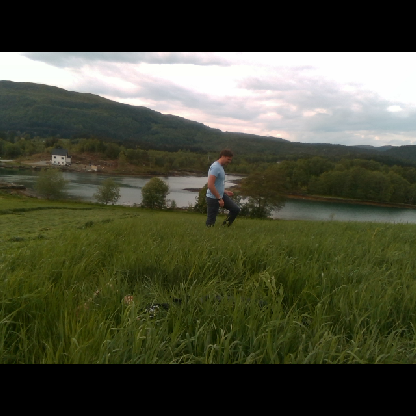

In [29]:
Image.fromarray(arr[0])

In [52]:
conf_thres = 0.8
nms_thres = 0.5

In [53]:
model.eval()
with torch.no_grad():
    outputs = model(imgs)
    outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)


In [54]:
#(x1, y1, x2, y2, object_conf, class_score, class_pred)
outputs[0].shape

torch.Size([3, 7])

In [55]:
boxes = outputs[0].cpu().numpy()[:,:4]
boxes.shape

(3, 4)

In [56]:
#outputs[:1][0:6].shape

In [57]:
def get_rect(x, y, width, height):
    rect = [(x, y), (x+width, y), (x+width, y+height), (x, y+height), (x, y)]
    #rect = [(0, 0), (width, height)]
    return tuple(rect)

(416, 416) RGB


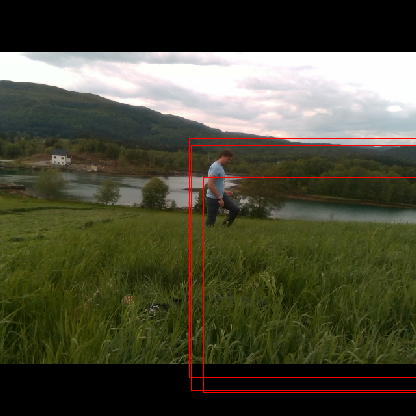

In [58]:
from PIL import ImageDraw

image = Image.fromarray(arr[0])
print (image.size, image.mode)
pshape = imgs.shape

#overlay = Image.new("L", (pshape[3], pshape[2]), 0)
#draw = ImageDraw.Draw(overlay)
draw = ImageDraw.Draw(image)

rects = [get_rect(*p) for p in boxes[:8]]

for rect in rects:
    draw.line([tuple(p) for p in rect], width=1, fill=255)

    
#img = Image.merge("RGB", (image,overlay,image))
image

In [59]:
# pick one image from the test set
img, img2 = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

NameError: name 'dataset_test' is not defined

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
print(img2.keys())
print(img2['boxes'])
mshape = img2['masks'].shape
arr = np.zeros((mshape[1],mshape[2]),dtype=np.uint8)
for i in range(mshape[0]):
    print ("load")
    arr += img2['masks'][i].mul(255).byte().numpy()
print (arr, np.unique(arr), arr.shape, type(arr))
image = Image.fromarray(arr)
image

In [ ]:
def get_rect(x, y, width, height):
    rect = [(x, y), (x+width, y), (x+width, y+height), (x, y+height), (x, y)]
    #rect = [(0, 0), (width, height)]
    
    return tuple(rect)

In [ ]:
from PIL import ImageDraw
pshape = prediction[0]['masks'].shape
boxes = prediction[0]['boxes'].cpu().numpy()
print(prediction[0]['masks'].shape)

arr = np.zeros((pshape[2],pshape[3]),dtype=np.uint8)
for i in range(pshape[0]):
    arr += prediction[0]['masks'][i,0].mul(255).byte().cpu().numpy()
image = Image.fromarray(arr)


overlay = Image.new("L", (pshape[3], pshape[2]), 0)
draw = ImageDraw.Draw(overlay)
rects = [get_rect(*p) for p in boxes]

for rect in rects:
    draw.line([tuple(p) for p in rect], width=3, fill=500)


print(image.size)
print(overlay.size)

img = Image.merge("RGB", (image,overlay,image))
(image,overlay)
img